# Анализ лояльности пользователей Яндекс Афиши (итоговый проект модуля 2 DS)

**Выполнил: Леонтьев Алексей**

Дата подготовки задания: 03.01.2025

# Описание проекта #

Команда маркетинга хочет лучше понимать **поведение пользователей**. Для этого они просят вас провести исследовательский анализ данных, чтобы понять, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. 

Это позволит:
- Быстро выявлять **перспективных клиентов** и предлагать им **персонализированные условия**.
- Точно **настраивать рекламу** на аудитории с высокой вероятностью возврата.
- **Оптимизировать маркетинговые бюджеты**.
- Повысить общий **уровень удержания клиентов**.

In [1]:
# Создам текущую дату для автоматического отображения
from datetime import datetime
from IPython.display import Markdown

today = datetime.today().strftime('%d.%m.%Y')
Markdown(f'**Дата отправки (текущая дата): {today}**')

**Дата отправки (текущая дата): 07.01.2026**

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [2]:
# используем библиотеки pandas и импортируем функцию из sqlalchemy для создания подключения к базе данных
import pandas as pd
from sqlalchemy import create_engine

In [3]:
# задаем конфигурации для подключения к базе данных
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [4]:
# формирую соедниения с помошью заданных конфигураций
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [5]:
# создание подключения к бд через create_engine из сформированной выше connection_string
engine = create_engine(connection_string)

In [6]:
# формирую query чтобы собрать нужные данные из бд в соответствии с заданием
query = '''
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,

    -- days_since_prev: разница дат (для первой покупки будет NULL)
    p.created_dt_msk::date
      - LAG(p.created_dt_msk::date) OVER (
          PARTITION BY p.user_id
          ORDER BY p.created_dt_msk::date
        ) AS days_since_prev,

    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases p
JOIN afisha.events e
  ON p.event_id = e.event_id
JOIN afisha.city c
  ON e.city_id = c.city_id
JOIN afisha.regions r
  ON c.region_id = r.region_id
WHERE
    p.device_type_canonical IN ('mobile', 'desktop')
    -- исключаем фильмы (регистронезависимо)
    AND LOWER(e.event_type_main) <> 'фильм'
ORDER BY p.user_id;
'''

In [7]:
# считываю query (формирую) df датафрейм из перенесенного postgresql запроса
df = pd.read_sql_query(query, con=engine)

In [8]:
## Посмотрим правильный ли выводится датафрейм, все ли столбы есть и все ли работает
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [9]:
df.shape

(290611, 15)

Объем данных 290 611  меньше,  чем исходный объем 292 034 так как мы отфильтровали данные о заказах, сделанных с редких типов устройств. В нашем датафрейме оставлена информация о покупках только с мобильных или десктопных устройств. Всего сформировано 15 колонок - тоже верно.

In [10]:
# проверим, что данные только с мобильных и десктопных устройств через value_counts
df['device_type_canonical'].value_counts()

device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

In [11]:
# посмотрим общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [12]:
df['currency_code'].value_counts()

currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

- В датафрейме присутсвует 4 типа данных: datetime64(2), float64(2), int64(3), object(8)
- Названия столбцов в snakecase
- Временные признаки:
    - пропусков нет, может быть потребуется извлечение доп. признаков (день недели, месяц и т.п.)
    - **нужно будет проверить на дубли!!!**
- Числовые признаки:
    - days_since_prev во float64, содержит 268 678 non-null из 290 611 (это 21 933 пропуска или примерно 7,5%), здесь пропуски означают, что отсутствует предыдущая покупка, их заполнять не надо
    - revenue во float64 - тип данных верный, пропусков нет, может быть понадобится проверить на наличие значений < 0, или выявить аномалии... в этом столбцы мы выявили две валюты (их приведем к рублям)
    - tickets_count в int64, пропусков нет, можно проверить наличие нулей (не куплены билеты?), посмотреть выбросы - слишков высокие значения
- категориальные признаки
    - 8 столбцов в формате object. Пропусков нигде нет, все столбцы готовы к дальнейшему анализу.

**Предварительный вывод по инфо о датафрейме:**

В результате SQL-выгрузки сформирован датасет из 290 611 строк и 15 столбцов, содержащий информацию о заказах пользователей, мероприятиях и их географическом расположении.

Типы данных в целом корректны: временные признаки представлены в формате datetime, числовые признаки — в соответствующих числовых форматах. В поле days_since_prev присутствуют пропущенные значения, что ожидаемо и соответствует первой покупке пользователя.

Пропусков в ключевых финансовых и категориальных признаках не обнаружено. Полученные данные готовы к дальнейшему этапу предобработки и исследовательского анализа.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [13]:
# выгрузим датафрейм из источника и выведем посмотреть на начало таблицы
tenge_df = pd.read_csv(
    'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
)

tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [14]:
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [15]:
# переименую колонку data в date чтобы потом не перепутать с данными при объединении и curs в rub_per_100_kzt чтобы не забыть, что это курс за 100 тенге 
tenge_df = tenge_df.rename(columns={'data': 'date', 'curs': 'rub_per_100_kzt'})

In [16]:
# приведу даты к datetime64 типу
tenge_df['date'] = pd.to_datetime(tenge_df['date'])

In [17]:
tenge_df.head()

,date,nominal,rub_per_100_kzt,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [18]:
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             357 non-null    datetime64[ns]
 1   nominal          357 non-null    int64         
 2   rub_per_100_kzt  357 non-null    float64       
 3   cdx              357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [19]:
# Объединяю датафреймы методом left по столбцам order_dt из df и date из tenge_df 
df = df.merge(
    tenge_df[['date', 'nominal', 'rub_per_100_kzt']],
    left_on='order_dt',
    right_on='date',
    how='left'
)

In [20]:
# создам новый столбец revenue_rub и скопирую в него исходные данные из revenue
df['revenue_rub'] = df['revenue']

In [21]:
# создадим маску для заказов в тенге (если True в тенге, если False в руб) 
mask_kzt = df['currency_code'] == 'kzt'

In [22]:
# перерасчет выручки для заказов в тенге, использую .loc чтобы выбирать нужные столбцы и производить с ними действия

# взял исх выручку в тенге и столбец revenue_rub в который будем записывать результат перерасчета
df.loc[mask_kzt, 'revenue_rub'] = (
    # далее беру столбец revenue где суммы в kzt и умножаю на курс rub_per_100_kzt и делю на 100 т.к. курс в руб за 100 тенге
    df.loc[mask_kzt, 'revenue']
    * df.loc[mask_kzt, 'rub_per_100_kzt']
    / 100
)

In [23]:
# на всякий случай проверю не возникло ли там пропусков
df.loc[mask_kzt, 'rub_per_100_kzt'].isna().sum()

np.int64(0)

In [24]:
# выведем часть информации, чтобы посмотреть что получилось
df.loc[mask_kzt, ['order_dt', 'revenue', 'rub_per_100_kzt', 'nominal', 'revenue_rub']].head()

,order_dt,revenue,rub_per_100_kzt,nominal,revenue_rub
70,2024-09-17,518.10,19.0125,100,98.503762
89,2024-09-02,347.18,18.9330,100,65.731589
96,2024-09-09,328.77,18.5991,100,61.148261
277,2024-06-11,22021.55,19.8928,100,4380.702898
460,2024-06-04,7397.66,19.9833,100,1478.296591


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

**Всё верно - пропуски только в days_since_prev**

Категориальные признаки можно перевести из object  в category. Выберем столбцы для преобразования:
- device_type_canonical
- currency_code
- event_type_main
- event_name
- service_name
- region_name
- city_name

In [26]:
# создам набор столбцов

cat_cols = [
    'device_type_canonical',
    'currency_code',
    'event_type_main',
    'event_name',
    'service_name',
    'region_name',
    'city_name'
]

# теперь перевожу этот набор столбцов из object в category

df[cat_cols] = df[cat_cols].astype('category')

**преобразование числовых типов с помощью downcast**

In [27]:
# преобразуем int64 в меньший разряд
int_cols = ['order_id', 'tickets_count', 'event_id', 'nominal']
for col in int_cols:
    df[col] = pd.to_numeric(df[col], downcast='integer')

# преобразуем float64  в меньший разряд
float_cols = ['revenue', 'revenue_rub', 'rub_per_100_kzt']
for col in float_cols:
    df[col] = pd.to_numeric(df[col], downcast='float')


In [28]:
# преобразуем также days_since_prev в int32 как целые числа дней
df['days_since_prev'] = df['days_since_prev'].round().astype('Int32')

In [29]:
# удаляю столбцы, которые использовалиь для расчетов
df = df.drop(columns=['date', 'nominal', 'rub_per_100_kzt'])

In [30]:
# посмотрим, что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  Int32         
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  category      
 11  event_type_main        290611 non-null  category      
 12  service_name           290611 non-null  cate

In [31]:
# Выведем уникальные значения по одельным столбцам, чтобы определить есть ли ошибки
for col in cat_cols:
    print(f'\n ')
    print(df[col].value_counts(dropna=False).head(10))


 
device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

 
currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

 
event_type_main
концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: count, dtype: int64

 
event_name
9cc55c15-4375-4129-9979-3129688ba1b4    3953
a00e1032-6463-4fdc-a105-fdbb6789b556    2519
0714435e-3b5f-4312-aa36-c3a9d8853ef4    1761
58574140-962c-49a3-af70-b773a05661a3    1749
e252d33a-2394-44b8-b11d-f0709a6f0260    1628
bc9866ed-5115-4288-8b19-21ae9735fba4    1579
d4344522-b7cf-4539-96c8-efece75e9b16    1490
0686ac7b-6f3e-4177-bb73-16b54acd1223    1456
2802fc66-4268-4529-8b4d-35a6a77ac375    1445
76af4f88-c554-4e9e-9df4-1cc8aeec8959    1327
Name: count, dtype: int64

 
service_name
Билеты без проблем    63519
Лови билет!           41124
Билеты в руки         40343
Мой билет             34839
Облачко               26642
Лучшие билеты     

In [32]:
# подсчет, есть ли в значениям "плохие", мешающие значения
for col in cat_cols:
    bad_values = df[col].isin(['unknown', 'none', 'nan', 'null', ''])
    print(col, bad_values.sum())


device_type_canonical 0
currency_code 0
event_type_main 0
event_name 0
service_name 0
region_name 0
city_name 0


In [33]:
# посмотрим статистику через .describe и дополним персентилями
df[['revenue_rub', 'tickets_count']].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

,revenue_rub,tickets_count
count,290611.000000,290611.000000
mean,555.571987,2.754311
std,875.498172,1.170620
min,-90.760000,1.000000
1%,0.000000,1.000000
5%,16.830000,1.000000
50%,351.140000,3.000000
95%,1630.650000,5.000000
99%,2628.421739,6.000000
max,81174.540000,57.000000


In [34]:
# отрицательная выручка
(df['revenue_rub'] < 0).sum()

np.int64(381)

In [35]:

# нулевая выручка
(df['revenue_rub'] == 0).sum()


np.int64(5526)

In [36]:

# нулевые билеты
(df['tickets_count'] == 0).sum()

np.int64(0)

**Заметка:** у нас выяснилось, что есть:
- 381 значение где выручка отрицательная в revenue_rub
- 5526 значений, где выручка нулевая в revenue_rub

Билетов с нулевыми значениями по количеству не обнаружено.

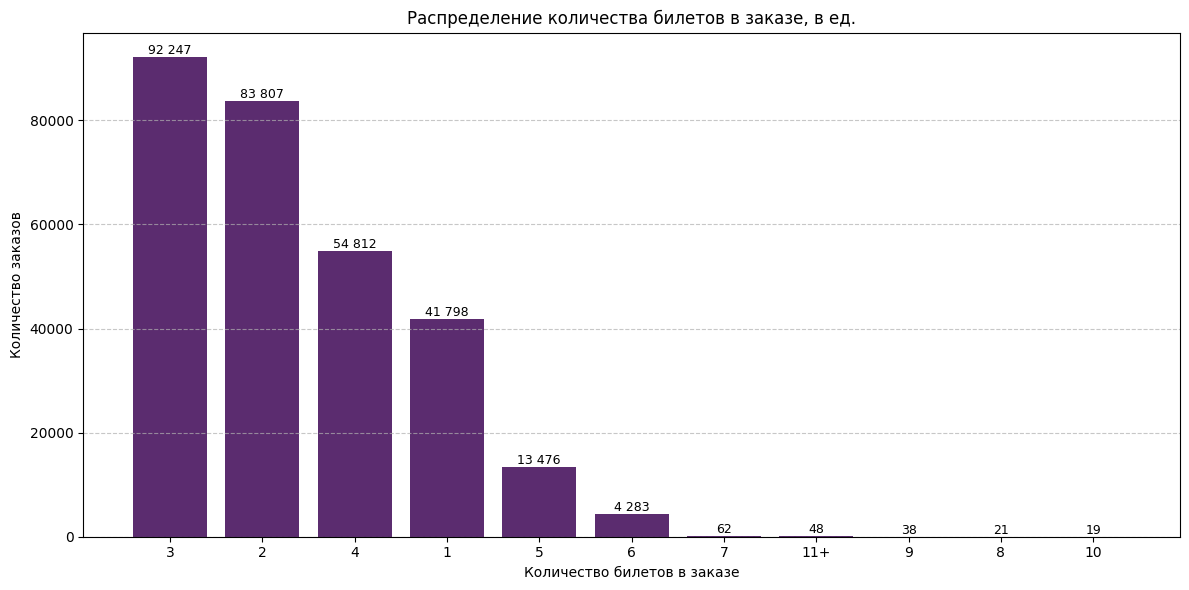

In [37]:
import matplotlib.pyplot as plt

# Задаю максимальный параметр: до какого значения показываем отдельно
max_k = 10  

# частоты tickets_count (сколько заказов для каждого числа билетов)
vc = df['tickets_count'].value_counts().sort_index()

# берём значения от 1 до max_k отдельно
vc_head = vc[vc.index <= max_k]

# всё, что больше max_k, объединяем (в хвост, в суммарное объединенное значение)
other = vc[vc.index > max_k].sum()

# собираем итоговую серию для графика: 1..max_k + (max_k+1) как "max_k+"
vc_plot = vc_head.copy()
vc_plot.loc[max_k + 1] = other  # технический индекс для хвоста, подпишем как "max_k+"

# сортируем столбцы по убыванию частоты (количества заказов)
vc_plot_sorted = vc_plot.sort_values(ascending=False)

# готовим подписи по оси X:
#    обычные числа -> "1", "2", ..., а хвост (индекс max_k+1) -> "11+" 
labels = [
    str(i) if i != max_k + 1 else f'{max_k+1}+'   # берет labels 1-10 True, а если 11+, то False. Если False, то выводит не просто 11, а 11 со знаком +      
    for i in vc_plot_sorted.index
]

# определяет значения подписей столбцов по высоте (количеству заказов) .values
values = vc_plot_sorted.values

# рисуем график
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color='#5B2C6F')

plt.title('Распределение количества билетов в заказе, в ед.')
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Количество заказов')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# подписи над столбцами — в абсолютных значениях, чтобы были видны редкие категории
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height):,}'.replace(',', ' '),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()


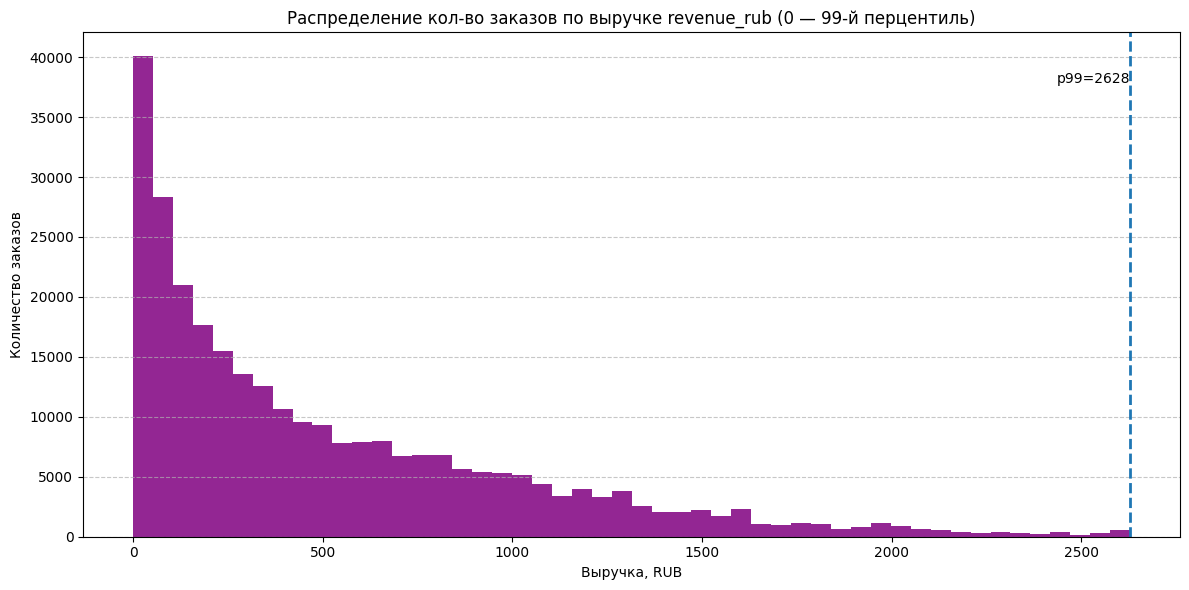

In [38]:
# Вычисляем 99-й перцентиль по выручке в рублях.
# Это значение, ниже которого находится 99% всех заказов.
p99 = df['revenue_rub'].quantile(0.99)

# Отбираем значения revenue_rub в диапазоне от 0 до p99 включительно.
# Таким образом, мы исключаем экстремальные выбросы (верхний 1%),
# чтобы основной массив данных был лучше виден на гистограмме. Также отсёк отрицательные значения (скорее всего <0 - это возвраты.
plot_series = df.loc[df['revenue_rub'].between(0, p99), 'revenue_rub']

# Создаём фигуру для построения графика
plt.figure(figsize=(12, 6))

# Строим гистограмму распределения revenue_rub:
# bins=50 — количество столбцов (интервалов),
# alpha — прозрачность столбцов
plt.hist(plot_series, bins=50, color='#800080', alpha=0.85)

plt.title('Распределение кол-во заказов по выручке revenue_rub (0 — 99-й перцентиль)')
plt.xlabel('Выручка, RUB')
plt.ylabel('Количество заказов')

# добавляем горизонтальную сетку для удобства визуального анализа
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем вертикальную линию, обозначающую значение 99-го перцентиля
plt.axvline(p99, linestyle='--', linewidth=2)
plt.text(p99, plt.ylim()[1]*0.9, f'p99={p99:.0f}', ha='right')

# автоматически подгоняем отступы
plt.tight_layout()

# выводим график
plt.show()


**Выводы по гистограмме revenue_rub**

- БОльшая часть заказов (столбцы по 5-40 тыс ед.) имеет небольшую выручку до 1000 руб. 
- Далее от 1000 до 2000 руб. частота по количеству значений находится на уровне ниже 5 тыс. ед.
- Длинный правый хвост характеризуется с редкими по частоте значениями в заказы на 2000 - 2500 руб.
  
Распределение выручки с заказа имеет выраженную правостороннюю асимметрию: основная часть заказов характеризуется сравнительно небольшой суммой, тогда как высокие значения выручки встречаются значительно реже и формируют длинный правый хвост распределения.

Около 99% заказов имеют выручку не выше 2.6 тыс. рублей. Значения выше данного порога можно рассматривать как статистические выбросы, которые могут быть связаны с групповыми или корпоративными покупками. Для повышения устойчивости дальнейшего анализа такие значения целесообразно исключать или анализировать отдельно.

**Справочно** 

В данных присутствуют заказы с нулевой и отрицательной выручкой. Такие значения могут быть связаны с возвратами билетов, отменой заказов или корректировками. Поскольку они не отражают фактическое потребительское поведение, при анализе распределения выручки они были исключены из визуализаций и учитываются отдельно на этапе предобработки.

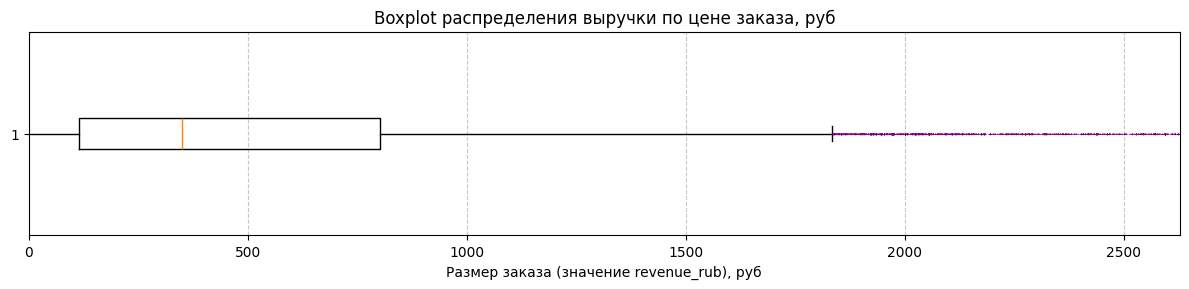

In [39]:

# Создаём фигуру для построения boxplot
plt.figure(figsize=(12, 3))

# Строим boxplot для распределения выручки:
# - dropna() удаляет пропущенные значения,
# - vert=False задаёт горизонтальную ориентацию,
# - flierprops управляет отображением выбросов (outliers)
plt.boxplot(
    df['revenue_rub'].dropna(),
    vert=False,
    flierprops=dict(
        marker='v',
        markersize=0.2,      # маленькие точки
        alpha=0.5,         # полупрозрачные
        markeredgecolor='purple'
    )
)

plt.title('Boxplot распределения выручки по цене заказа, руб')
plt.xlabel('Размер заказа (значение revenue_rub), руб')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xlim(0, p99)

plt.tight_layout()
plt.show()

Из диаграммы boxplot видно, что 
- распределение выручки имеет выраженную правостороннюю ассиметрию. медиана расположена ближе к левой (или нижней если смотреть вертикально) границе коробки. Хвост намного длиннее справа. Это означает, что большинство заказов имеют относительно небольшую выручку. Высокие значения по выручки более 1700 руб. встречаются редко;
- основная масса заказов находится в узком диапазоне: межквартильный размах Q1-Q3 значительно уже, чем общий диапазон значений, средний чек примерно одинаковый (повдение покупателей одинаковое - они покупают 1-3 билета в средней ценовой категории;
- наблюдается большое количество выбросов по выручке, которые находятся в положительном диапазоне значений. Возможно, кто-то закупал большое количество билетов, были дорогие мероприятия, оплаты за корпоративные или групповые мероприятия. Однако, это не типичное поведение пользователей.

Из-за длинного хвоста среднее значение по выручке выше медианы. Принимаем медиану, как более устойчивый показатель, нежели среднее значение.

In [40]:
# Порог по 99-му перцентилю
p99 = df['revenue_rub'].quantile(0.99)

# Размер датасета до фильтрации
rows_before = df.shape[0]

# Количество строк, которые будут отфильтрованы
rows_filtered = (df['revenue_rub'] > p99).sum()

# Размер датасета после фильтрации
rows_after = rows_before - rows_filtered

# Доля отфильтрованных данных, %
filtered_share = rows_filtered / rows_before * 100

rows_before, rows_after, rows_filtered, filtered_share

(290611, np.int64(287786), np.int64(2825), np.float64(0.9720898383061893))

In [41]:
p99 = df['revenue_rub'].quantile(0.99)

df_clean = df[df['revenue_rub'] <= p99].copy()

In [42]:
df.shape[0], df_clean.shape[0]

(290611, 287786)

In [43]:
rows_filtered = rows_before - rows_after
filtered_share = rows_filtered / rows_before * 100

rows_filtered, filtered_share

(np.int64(2825), np.float64(0.9720898383061893))

**Вывод:** после фильтрации выбросов по revenue_rub датасет уменьшился примерно на 1%.

**Основные выполненные шаги:**
- Проверены и приведены типы данных:
    - даты и время — datetime64;
    - числовые признаки оптимизированы;
    - категориальные признаки приведены к category.
- Приведена выручка к единой валюте (RUB) и создан новый столбец revenue_rub.
- Проанализированы номинальные признаки:
    - не выявлены категории, обозначающие пропуски или отсутствие информации.
- Проанализированы числовые признаки revenue_rub и tickets_count:
    - выявлены выбросы в revenue_rub.
- Выполнена фильтрация выбросов:
    - удалены значения revenue_rub выше 99-го перцентиля.

**Описание новых столбцов**

Были добавлены новые признаки:
- **revenue_rub** — выручка заказа, приведённая к рублям РФ с учётом дневного курса валют тенге;
- **days_since_prev** — количество дней между текущим и предыдущим заказом пользователя (для первой покупки — пропуск).

### Промежуточный вывод ###
После выполнения предобработки данных была проведена проверка объёма датасета. В результате фильтрации выбросов по 99-му перцентилю значения выручки revenue_rub было удалено 2870 заказов, что составляет около 1% от общего объёма данных.

Основные типы данных были приведены к корректным форматам, числовые и категориальные признаки оптимизированы. Выручка заказов приведена к единой валюте — российскому рублю, для чего был сформирован новый столбец revenue_rub.

Также был рассчитан признак days_since_prev, отражающий количество дней между покупками пользователя. В номинальных признаках не выявлено значений, обозначающих пропуски или отсутствие информации.

После выполненных преобразований датасет стал более удобным для дальнейшего анализа.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---

In [44]:
# отсортируем заказы по времени
df_sorted = df_clean.sort_values(['user_id', 'order_ts'])

In [45]:
# берем первую строку для каждого user_id

first_order = (
    df_sorted
    .groupby('user_id', as_index=False)
    .first()
    [['user_id',
      'order_dt',
      'device_type_canonical',
      'region_name',
      'service_name',
      'event_type_main']]
)

In [46]:
# переименую столбцы, чтобы отличать первые и последующие заказы
first_order = first_order.rename(columns={
    'order_dt': 'first_order_dt',
    'device_type_canonical': 'first_device',
    'region_name': 'first_region',
    'service_name': 'first_service',
    'event_type_main': 'first_event_type' # использовал поле event_type_main
})

In [47]:
# рассчитываю поведенческие метрики (статистику) 

user_stats = (
    df_clean
    .groupby('user_id', as_index=False)
    .agg(
        last_order_dt=('order_dt', 'max'), 
        orders_count=('order_id', 'nunique'),
        avg_revenue_rub=('revenue_rub', 'mean'),
        avg_tickets=('tickets_count', 'mean'),
        avg_days_between_orders=('days_since_prev', 'mean')
    )
)

In [48]:
# объединяю в единый профиль пользователя через .merge left

user_profile = first_order.merge(
    user_stats,
    on='user_id',
    how='left'
)

In [49]:
user_profile['is_two'] = user_profile['orders_count'] >= 2 # добавляю бинарный признак для пользователей с 2-мя и более заказами 
user_profile['is_five'] = user_profile['orders_count'] >= 5 # добавляю бинарный признак для пользователей с 5-тью и более заказами 

In [50]:
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21854 entries, 0 to 21853
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21854 non-null  object        
 1   first_order_dt           21854 non-null  datetime64[ns]
 2   first_device             21854 non-null  category      
 3   first_region             21854 non-null  category      
 4   first_service            21854 non-null  category      
 5   first_event_type         21854 non-null  category      
 6   last_order_dt            21854 non-null  datetime64[ns]
 7   orders_count             21854 non-null  int64         
 8   avg_revenue_rub          21854 non-null  float64       
 9   avg_tickets              21854 non-null  float64       
 10  avg_days_between_orders  13513 non-null  Float64       
 11  is_two                   21854 non-null  bool          
 12  is_five                  21854 n

Проверим по чек-листу единый профиль пользователя, который должен был получиться:
1) first_order_dt - дата первого и последнего заказа;
2) first_device - устройство, с которого был сделан первый заказ;
3) first_region - регион, в котором был сделан первый заказ;
4) first_service - билетный партнёр, к которому обращались при первом заказе;
5) first_event_type - жанр первого посещённого мероприятия (использовал поле event_type_main);
6) last_order_dt - последняя дата заказа;
7) orders_count - общее количество заказов;
8) avg_revenue_rub - средняя выручка с одного заказа в рублях;
9) avg_tickets - среднее количество билетов в заказе;
10) avg_days_between_orders - среднее время между заказами.
Два бинарных признака:
11) is_two — совершил ли пользователь 2 и более заказа;
12) is_five — совершил ли пользователь 5 и более заказов.

Значений в user_profile 21854, при этом avg_days_between_orders  13513 (есть NA, т.к. дата первого заказа и дата последнего совпадает, то среднее время между заказами не определено).

In [51]:
user_profile.head()

,user_id,first_order_dt,first_device,first_region,first_service,first_event_type,last_order_dt,orders_count,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,mobile,Каменевский регион,Край билетов,театр,2024-08-20,1,1521.940000,4.000000,<NA>,False,False
1,0005ca5e93f2cf4,2024-07-23,mobile,Каменевский регион,Мой билет,выставки,2024-10-06,2,774.010000,3.000000,75.0,True,False
2,000898990054619,2024-07-13,mobile,Североярская область,Лови билет!,другое,2024-10-23,3,767.213333,2.666667,51.0,True,False
3,00096d1f542ab2b,2024-08-15,desktop,Каменевский регион,Край билетов,театр,2024-08-15,1,917.830000,4.000000,<NA>,False,False
4,000a55a418c128c,2024-09-29,mobile,Поленовский край,Лучшие билеты,театр,2024-10-15,2,61.310000,1.500000,16.0,True,False


Для формирования профиля пользователя данные были агрегированы на уровне user_id. Для каждого пользователя определены дата первого и последнего заказа, а также характеристики первого заказа: устройство, регион, билетный партнёр и тип мероприятия.

Дополнительно рассчитаны поведенческие показатели: общее количество заказов, средняя выручка с заказа, среднее количество билетов и среднее время между заказами.

Для последующего моделирования добавлены бинарные признаки is_two и is_five, отражающие факт совершения пользователем двух и более и пяти и более заказов соответственно.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [52]:
total_users = user_profile.shape[0]
total_users

21854

В выборке 21854 пользователей — это достаточный объём для анализа поведения и лояльности.

In [53]:
# рассчитаем среднюю выручку с одного заказа

avg_order_revenue = user_profile['avg_revenue_rub'].mean()
avg_order_revenue


np.float64(544.398050897431)

In [54]:
# рассчитаем долю пользователей с 2 и более заказами (найдем среднее для которого is_two True)

share_two_plus = user_profile['is_two'].mean()
share_two_plus

np.float64(0.6170952686007138)

In [55]:
# рассчитаем долю пользователей с 5 и более заказами

share_five_plus = user_profile['is_five'].mean()
share_five_plus

np.float64(0.2900613160062231)

In [56]:
# рассчитываю статистику по количеству заказов
user_profile['orders_count'].describe(percentiles=[0.95, 0.99])

count    21854.000000
mean        13.168573
std        121.674800
min          1.000000
50%          2.000000
95%         31.350000
99%        152.000000
max      10181.000000
Name: orders_count, dtype: float64

В статистике по количеству заказов выделяется максимальное значение 10181 - это слишком большое значение, явная аномалия. Возможно в данных еше есть аномальные значения, которые можно посмотреть далее. Из-за аномалий искажается среднее значение, которое составляет 13 заказов, при этом медиана (более реальистичное значение для типичных заказов) составляет 2 заказа. также большое стандартное отклонение 121.6, которое почти в 10 раз больше срденего и в 50 раз больше медианы, подтверждает наличие сверх-аномальных значений, искажающих статистику.

In [57]:
# выведу топ пользователей по количеству заказов
user_profile.sort_values('orders_count', ascending=False).head(10)

,user_id,first_order_dt,first_device,first_region,first_service,first_event_type,last_order_dt,orders_count,avg_revenue_rub,avg_tickets,avg_days_between_orders,is_two,is_five
981,0beb8fc0c0a9ce1,2024-06-01,mobile,Североярская область,Билеты в руки,концерты,2024-10-31,10181,505.152314,2.862587,0.014833,True,True
2054,18e9aead0a393e7,2024-06-01,mobile,Каменевский регион,Облачко,концерты,2024-10-31,4351,494.827281,2.788784,0.034253,True,True
11073,8187dac4be757a0,2024-06-01,mobile,Берёзовская область,Билеты в руки,концерты,2024-10-31,4021,537.419684,2.747078,0.037562,True,True
5414,3ee7dc2e115847f,2024-06-01,mobile,Каменевский регион,Мой билет,концерты,2024-10-31,3791,536.949699,2.764970,0.039842,True,True
10810,7eb4fc207ecc10f,2024-06-01,mobile,Каменевский регион,Билеты без проблем,театр,2024-10-31,3710,542.634238,2.956334,0.040442,True,True
2330,1c2a2133e1df1b4,2024-06-01,mobile,Североярская область,Реестр,концерты,2024-10-31,3503,541.560246,2.669997,0.043118,True,True
6776,4ec8f6429431987,2024-06-01,mobile,Североярская область,Реестр,концерты,2024-10-31,3375,549.785176,2.725926,0.044161,True,True
14765,ad2dc32364ed948,2024-06-01,mobile,Яблоневская область,Лови билет!,театр,2024-10-31,3249,447.725539,2.939674,0.046798,True,True
15502,b54dd0cd81121fc,2024-06-01,mobile,Берёзовская область,Лови билет!,другое,2024-10-31,3138,481.607860,2.813257,0.047816,True,True
17634,cdbc02c6ad8087a,2024-06-01,mobile,Чистогорская область,Лови билет!,спорт,2024-10-31,3036,466.968526,2.764163,0.048764,True,True


Здесь видно, что пользователь `0beb8fc0c0a9ce1` действительно с 01.06 по 31.10 в 2024 году набрал более 10 тыс заказов. Есть также и другие отдельные пользователи, с заказами 3-4 тыс. ед. Возможно это партнеры, агенства или организаторы мероприятий. **Нужно будет решить, что делать с такими аномалиями, чтобы корректно провести анализ лояльности.**

In [58]:
user_profile['avg_tickets'].describe(percentiles=[0.95, 0.99])

count    21854.000000
mean         2.743129
std          0.913080
min          1.000000
50%          2.750000
95%          4.000000
99%          5.000000
max         11.000000
Name: avg_tickets, dtype: float64

Для avg_tickets по статистике видно, что максимальное значени 11, в то время как среднее 2.7, почти совпадает с медианой 2.75, в хвосте (более редкие случаи) покупки билетов в кол-ве более 5. Можно считать 5-11 билетов аномалией, но эти значения не искажают статистику по среднему значению.

In [59]:
# Теперь посмотрим статистику для `avg_days_between_orders`
user_profile['avg_days_between_orders'].describe(percentiles=[0.95, 0.99])

count      13513.0
mean     15.851275
std      22.306224
min            0.0
50%            8.0
95%           61.5
99%          112.0
max          148.0
Name: avg_days_between_orders, dtype: Float64

Мы имеем значения примерно для 60% значений которые насчитывают 13513. При этом пропуски это когда пользователи заказали один раз и больше не заказывали. Среднее 15.8 дней более чем в два раза отличается от медианы 8 дней. Некоторые заказывают очень редко 99-й персентиль от 112 дней и максимальное значение 148 дней - это тоже можно ситать аномалиями. При этом лучше ориентироваться на медиану для типичной частоты заказов - 8 дней.

In [60]:
# Рассчитываем 99-й перцентиль по количеству заказов на пользователя.
# Это значение используем как верхнюю границу "нормального" поведения.
p99_orders = user_profile['orders_count'].quantile(0.99)

# Число пользователей до фильтрации
rows_before = user_profile.shape[0]

# Фильтруем пользователей с экстремально большим числом заказов
# Оставляем только тех, у кого количество заказов не превышает p99
user_profile_filt = user_profile[
    user_profile['orders_count'] <= p99_orders
].copy()

# Число пользователей после фильтрации
rows_after = user_profile_filt.shape[0]

# Доля отфильтрованных пользователей в процентах
filtered_share = (rows_before - rows_after) / rows_before * 100

rows_before, rows_after, filtered_share

(21854, 21638, 0.9883774137457674)

После фильтрации по 99-му перцентилю количества заказов было удалено около 1% пользователей (216 из 21854). Это небольшая доля данных, которая не влияет на репрезентативность выборки, но позволяет снизить влияние экстремальных значений на статистику.

Далее посмотрим на статистику после фильтрации.

In [61]:
# Анализируем статистические показатели после фильтрации
# Сравниваем распределения с исходными значениями

user_profile_filt[
    ['orders_count', 'avg_tickets', 'avg_days_between_orders']
].describe(percentiles=[0.95, 0.99])

,orders_count,avg_tickets,avg_days_between_orders
count,21638.000000,21638.000000,13297.0
mean,6.501294,2.743319,16.101314
std,14.324031,0.917486,22.399512
min,1.000000,1.000000,0.0
50%,2.000000,2.750000,8.352941
95%,26.000000,4.000000,62.0
99%,80.000000,5.000000,113.0
max,152.000000,11.000000,148.0


- Для orders_count: max снизился с 10181 до 152, mean снизился с 13.2 до 6.5, медиана не изменилась и составляет 2. Влияние аномалий нивелировали.
- Для avg_tickets: статистика почти не изменилась, mean и median остались ≈ 2.7, max = 11. Подтверждается, что 5-11 не искажают статистику.
- Для avg_days_between_order: медиана 8 дней, хвост остался 148 дней, распределение осталось ассиметричным, значит фильтрация по orders-count не разрушила временные харастеристики.

**Выводы по задаче 3.2**
1) Для `orders_count`
   В данных по количеству заказов выявлены экстремальные значения: у отдельных пользователей число заказов достигает 10 тысяч и более, при медианном значении 2 заказа. Эти аномалии существенно искажают средние показатели и стандартное отклонение. Для корректного анализа поведения типичных пользователей была применена фильтрация по 99-му перцентилю количества заказов, в результате которой было исключено около 1% пользователей. Это позволило снизить влияние экстремальных значений без потери репрезентативности выборки.
2) Для `avg_tickets`
   Распределение среднего количества билетов в заказе является устойчивым: среднее значение практически совпадает с медианой. В хвосте распределения встречаются заказы с 5–11 билетами, которые можно считать редкими, но они не оказывают существенного влияния на общую статистику. Фильтрация по данному признаку не требуется.
3) Для `avg_days_between_orders`
   Среднее время между заказами характеризуется правосторонней асимметрией: медиана составляет около 8 дней, тогда как среднее значение превышает 15 дней за счёт редких пользователей с большими интервалами между покупками. Пропуски в данном признаке связаны с пользователями, совершившими только одну покупку, и являются логически корректными. Для анализа типичного поведения рекомендуется ориентироваться на медианные значения.

В выборке представлено 21,8 тыс. пользователей, что является достаточным объёмом данных для анализа поведения и возврата пользователей. Анализ профилей показал наличие аномальных значений в количестве заказов: у отдельных пользователей число заказов превышает 10 тысяч, что существенно искажает средние показатели.

Для снижения влияния экстремальных значений была применена фильтрация по 99-му перцентилю количества заказов, в результате которой было исключено около 1% пользователей. После фильтрации распределения стали более устойчивыми, при этом типичные значения (медианы) не изменились.

По среднему количеству билетов в заказе и среднему времени между покупками выявлены редкие значения в хвосте распределений, однако они не оказывают существенного влияния на статистику и отражают реальное поведение отдельных пользователей. Данные после фильтрации признаны пригодными для дальнейшего исследовательского анализа факторов лояльности.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.

#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [62]:
# Группируем пользователей по типу первого мероприятия
event_type_dist = (
    user_profile_filt
    .groupby('first_event_type', observed=True)
    .agg(users_count=('user_id', 'count'))
)

# Добавляем долю пользователей в процентах
event_type_dist['users_share_pct'] = (
    event_type_dist['users_count']
    / event_type_dist['users_count'].sum()
    * 100
)

# Сортируем по убыванию количества пользователей
event_type_dist = event_type_dist.sort_values('users_count', ascending=False)

event_type_dist

,users_count,users_share_pct
first_event_type,,
концерты,9560,44.181532
другое,5426,25.076255
театр,4239,19.590535
стендап,1110,5.129864
спорт,794,3.669470
выставки,414,1.913301
ёлки,95,0.439042


Пользователи чаще всего впервые взаимодействуют с платформой, заказывая билеты на концерты (9560 пользователей, 44%, через категорию "другое" (5426 пользователей, 25%) и театр (4239, почти 20%). Остальные точки входа как первого мероприятия составляют меньше 5% по долям пользователей.

In [63]:
# Группируем пользователей по типу устройства первого заказа
device_dist = (
    user_profile_filt
    .groupby('first_device', observed=True)
    .agg(users_count=('user_id', 'count'))
)

# Рассчитываем долю пользователей
device_dist['users_share_pct'] = (
    device_dist['users_count']
    / device_dist['users_count'].sum()
    * 100
)

# Сортируем по убыванию
device_dist = device_dist.sort_values('users_count', ascending=False)

device_dist

,users_count,users_share_pct
first_device,,
mobile,17924,82.835752
desktop,3714,17.164248


В основном пользователи делали первые заказы с мобильных устройств (почти 18 тыс пользователей, около 83%). Остальные 3714 пользователей (17%) c десктопа.

In [64]:
# Общее количество регионов, представленных в данных
total_regions = user_profile_filt['first_region'].nunique()
total_regions


81

In [65]:
# Строим агрегированную таблицу по регионам:
#    users_count — число пользователей, у которых первый заказ был в этом регионе
region_dist = (
    user_profile_filt
    .groupby('first_region', observed=True)
    .agg(users_count=('user_id', 'count'))
)

In [66]:
# Добавляем долю пользователей по каждому региону, %
region_dist['users_share_pct'] = (
    region_dist['users_count'] / region_dist['users_count'].sum() * 100
)

In [67]:
# Сортируем регионы по убыванию количества пользователей
region_dist = region_dist.sort_values('users_count', ascending=False)

In [68]:
# Берём топ-10 регионов
top_10_regions = region_dist.head(10)

In [69]:
# Все остальные регионы объединяем в категорию "Другие регионы"
other_regions = pd.DataFrame({
    'users_count': [region_dist.iloc[10:]['users_count'].sum()],
    'users_share_pct': [region_dist.iloc[10:]['users_share_pct'].sum()]
}, index=['Другие регионы'])

In [70]:
# Итоговая таблица: топ-10 + другие регионы
region_dist_top10 = pd.concat([top_10_regions, other_regions])

region_dist_top10

,users_count,users_share_pct
Каменевский регион,7085,32.743322
Североярская область,3767,17.409188
Широковская область,1224,5.656715
Озернинский край,675,3.119512
Малиновоярский округ,525,2.426287
Шанырский регион,500,2.310750
Травяная область,488,2.255292
Светополянский округ,457,2.112025
Речиновская область,440,2.033460
Яблоневская область,411,1.899436


Всего в данных представлен 81 регион. Из таблицы видно, что `Каменевский регион` (7085, 32.7%) и `Североярская область` (3767, 17.4%) это самые многочисленные регионы по количеству впервые проведенных мероприятий. Далее регионы набирали 5% и менее 2%. Остальные 71 регионы объединены и составляют 28%.

In [71]:
# Группируем пользователей по билетному оператору первого заказа
service_dist = (
    user_profile_filt
    .groupby('first_service', observed=True)
    .agg(users_count=('user_id', 'count'))
)

# Добавляем долю пользователей
service_dist['users_share_pct'] = (
    service_dist['users_count']
    / service_dist['users_count'].sum()
    * 100
)

# Сортируем по убыванию
service_dist = service_dist.sort_values('users_count', ascending=False)

service_dist

,users_count,users_share_pct
first_service,,
Билеты без проблем,5186,23.967095
Мой билет,2969,13.721231
Лови билет!,2809,12.981791
Билеты в руки,2559,11.826416
Облачко,2177,10.061004
Весь в билетах,1285,5.938626
Лучшие билеты,1184,5.471855
Прачечная,583,2.694334
Край билетов,454,2.098161


По билетному оператору можно выделить топ-5 операторов: `Билеты без проблем` (5186, 24%), `Мой билет` (2969, 13.7%), `Лови билет` (2809, 13%), `Билеты в руки` (2559, 12%), `Облачко` (2177, 10%). Остальные операторы набирали менее 6%.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [72]:
# Базовая доля пользователей, совершивших 2 и более заказа, по всей выборке
base_return_rate = user_profile_filt['is_two'].mean()

base_return_rate

np.float64(0.6132729457435993)

Доля пользователей, совершивших 2 и более заказа, составляет 61.3%

In [73]:
# Группируем пользователей по типу первого мероприятия
# Для каждого сегмента считаем:
# - количество пользователей
# - долю пользователей, совершивших повторный заказ (is_two)
event_type_return = (
    user_profile_filt
    .groupby('first_event_type', observed=True)
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
)

# Переводим долю возврата в проценты
event_type_return['return_rate_pct'] = event_type_return['return_rate'] * 100

# Сортируем по количеству пользователей
event_type_return = event_type_return.sort_values('users_count', ascending=False)

event_type_return

,users_count,return_rate,return_rate_pct
first_event_type,,,
концерты,9560,0.618305,61.830544
другое,5426,0.596203,59.620346
театр,4239,0.633876,63.387591
стендап,1110,0.609009,60.900901
спорт,794,0.557935,55.793451
выставки,414,0.640097,64.009662
ёлки,95,0.557895,55.789474


Мы наблюдаем, что в топ-3 типах мероприятий по количеству пользователей (концерты, другое, театр) - это не топ мероприятия на которые больше всего возвращались пользователи.

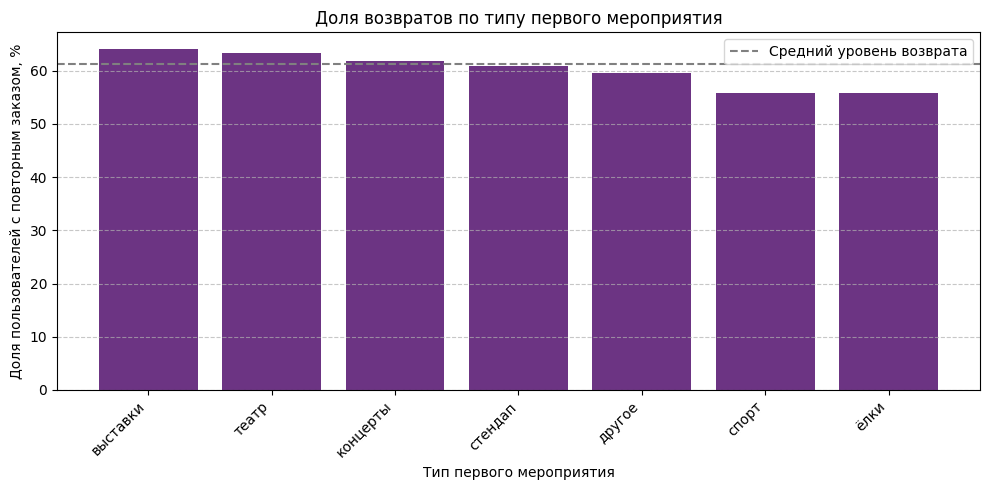

In [74]:
# отсортируем значения в таблице по return_rate для графика
event_type_return_sorted = event_type_return.sort_values('return_rate', ascending=False)

plt.figure(figsize=(10, 5))

bars = plt.bar(
    event_type_return_sorted.index,
    event_type_return_sorted['return_rate_pct'],
    color='#6C3483'
)

# Линия среднего уровня возврата
plt.axhline(
    base_return_rate * 100,
    linestyle='--',
    color='gray',
    label='Средний уровень возврата'
)

plt.title('Доля возвратов по типу первого мероприятия')
plt.xlabel('Тип первого мероприятия')
plt.ylabel('Доля пользователей с повторным заказом, %')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


Средний уровень возврата пользователей примерно находится на одинаковов уровень 55-64%, при этом для выставок и театров уровень возврата пользователей чуть выше среднего. Концерты совпадают со средним уровнем возврата.

In [75]:
# Анализ возвратов по типу устройства первого заказа
device_return = (
    user_profile_filt
    .groupby('first_device', observed=True)
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
)

device_return['return_rate_pct'] = device_return['return_rate'] * 100
device_return

,users_count,return_rate,return_rate_pct
first_device,,,
desktop,3714,0.638126,63.812601
mobile,17924,0.608123,60.812319


Не смотря на то, что по количеству пользователей, чаще используют мобильные устройства, по уровню возврата декстопные пользователи чаще возвращаются, чем пользователи мобильных устройств.

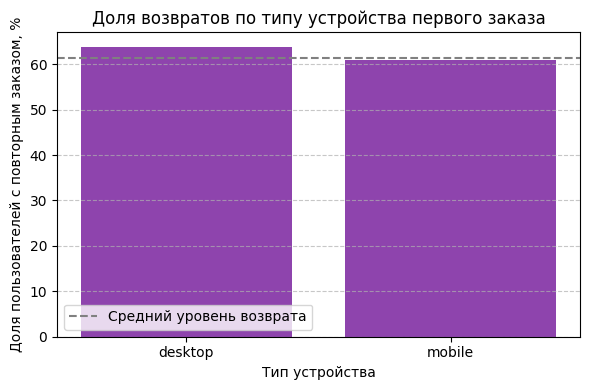

In [76]:
plt.figure(figsize=(6, 4))

bars = plt.bar(
    device_return.index,
    device_return['return_rate_pct'],
    color='#8E44AD'
)

plt.axhline(
    base_return_rate * 100,
    linestyle='--',
    color='gray',
    label='Средний уровень возврата'
)

plt.title('Доля возвратов по типу устройства первого заказа')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей с повторным заказом, %')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [77]:
# Группируем пользователей по региону первого заказа
region_return = (
    user_profile_filt
    .groupby('first_region', observed=True)
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
)

region_return['return_rate_pct'] = region_return['return_rate'] * 100

# Сортируем по числу пользователей и берём топ-10
region_return_top10 = region_return.sort_values(
    'users_count', ascending=False
).head(10)

region_return_top10

,users_count,return_rate,return_rate_pct
first_region,,,
Каменевский регион,7085,0.623994,62.399435
Североярская область,3767,0.638174,63.817361
Широковская область,1224,0.645425,64.542484
Озернинский край,675,0.552593,55.259259
Малиновоярский округ,525,0.560000,56.000000
Шанырский регион,500,0.672000,67.200000
Травяная область,488,0.614754,61.475410
Светополянский округ,457,0.656455,65.645514
Речиновская область,440,0.634091,63.409091


Также как в анализе по типам мероприятий, в анализе по регионам наблюдается что в топ-3 регионах по числу пользователей не наблюдается самый большой возврат пользователей.

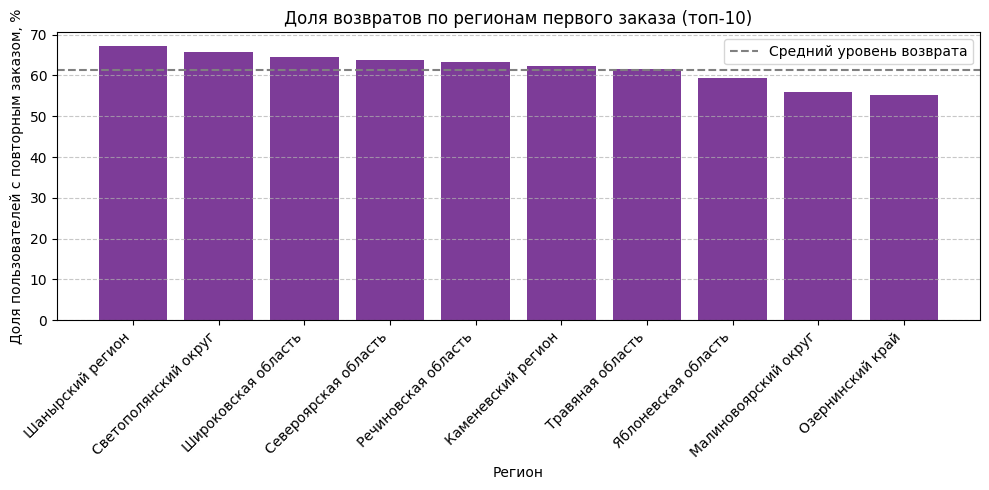

In [78]:
region_return_top10_sorted = region_return_top10.sort_values('return_rate', ascending=False)

plt.figure(figsize=(10, 5))

bars = plt.bar(
    region_return_top10_sorted.index,
    region_return_top10_sorted['return_rate_pct'],
    color='#7D3C98'
)

plt.axhline(
    base_return_rate * 100,
    linestyle='--',
    color='gray',
    label='Средний уровень возврата'
)

plt.title('Доля возвратов по регионам первого заказа (топ-10)')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей с повторным заказом, %')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

Топ регионы с долей пользователей, которые возвращаются с повторными заказами: Шанырский (500), Светополянский (457), Широковская обл (1224), Североярская обл (3767), Речиновская обл. (440). Показатели можно считать стаблиными так как для топ-3 региона данных достаточно для устойчивости статистических показателей.

In [79]:
# Анализ возвратов по билетным операторам первого заказа
service_return = (
    user_profile_filt
    .groupby('first_service', observed=True)
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
)

service_return['return_rate_pct'] = service_return['return_rate'] * 100

# Берём топ-10 операторов по числу пользователей
service_return_top10 = service_return.sort_values(
    'users_count', ascending=False
).head(10)

service_return_top10

,users_count,return_rate,return_rate_pct
first_service,,,
Билеты без проблем,5186,0.604126,60.412649
Мой билет,2969,0.608622,60.862243
Лови билет!,2809,0.609114,60.911356
Билеты в руки,2559,0.627198,62.719812
Облачко,2177,0.612770,61.276987
Весь в билетах,1285,0.628794,62.879377
Лучшие билеты,1184,0.612331,61.233108
Прачечная,583,0.626072,62.607204
Край билетов,454,0.651982,65.198238


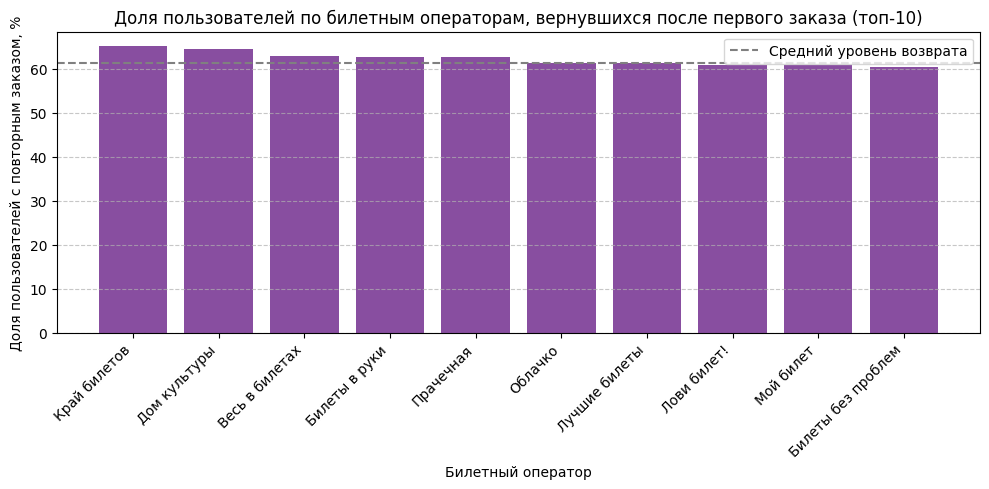

In [80]:
service_return_top10_sorted = service_return_top10.sort_values('return_rate', ascending=False)

plt.figure(figsize=(10, 5))

bars = plt.bar(
    service_return_top10_sorted.index,
    service_return_top10_sorted['return_rate_pct'],
    color='#884EA0'
)

plt.axhline(
    base_return_rate * 100,
    linestyle='--',
    color='gray',
    label='Средний уровень возврата'
)

plt.title('Доля пользователей по билетным операторам, вернувшихся после первого заказа (топ-10)')
plt.xlabel('Билетный оператор')
plt.ylabel('Доля пользователей с повторным заказом, %')

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

Среди наибольшего количества вернувшихся пользователей лидируют такие операторы как: Край билетов (454), Дом культуры (356), Весь в билетах(1285), у которых доля чуть выше среднего, однако и количество заказов не самое высокое - несколько сотен до тысячи двести, как указанно в скобках. Но в целом у всех операторов доля вернувшихся пользователей примерно на одинаковом уровне 60%.

**Итоговая информация для проверки гипотез**

Для первой гипотезы:
Возврат пользователей по типам мероприятий (return_rate в процентах):
- частота повторных заказов пользователей, которые совершили первый заказ на спортивные мероприятия
56%
- повторные заказы пользователей, которые совершили первый заказ на концерты
62%

Для второй гипотезы:
Доля повторных заказов в регионах, где больше всего пользователей посещают мероприятия (кол-во посещений; доля повторных заказов):
- Каменевский регион (7085;	62.4%)
- Североярская область (3767, 63.8%)
- Широковская область (1224; 64.5%)
Доля повторных заказов в менее активных регионах
- Шанырский (500; 67.2%)
- Светополянский (457; 65.6)
- Широковская область (1224; 64.5%)

Интересно, что Широковская область входит в топ три по активности и по доле возвращающихся пользователей.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Вывод по **гипотизе 1**: `нет, гипотеза не подтвердилась, т.к. исходя из анализа return_rate для спортивных мероприятий (56%) меньше, чем return_rate по заказам для концертов (62%).`

Вывод по **гипотизе 2**: `нет, гипотеза не подтвердилась, т.к. больше всего пользователей в Каменевском р-не и Североярской области, а больше всего повторных заказов в Шанырском и Светополянском р-не. Широковская обл. входит в топ-3 как по активности, так и по количеству возвращающихся пользователей.` 

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---

In [81]:
# Формируем две группы пользователей:
# 1) пользователи, совершившие только один заказ
one_order_users = user_profile_filt.loc[
    user_profile_filt['orders_count'] == 1, 'avg_revenue_rub'
]

# 2) пользователи, совершившие два и более заказа (вернувшиеся пользователи)
repeat_users = user_profile_filt.loc[
    user_profile_filt['orders_count'] >= 2, 'avg_revenue_rub'
]

In [82]:
# Рассчитываем 99-й перцентиль средней выручки с заказа
p99_revenue = user_profile_filt['avg_revenue_rub'].quantile(0.99)

p99_revenue

np.float64(1970.3100000000002)

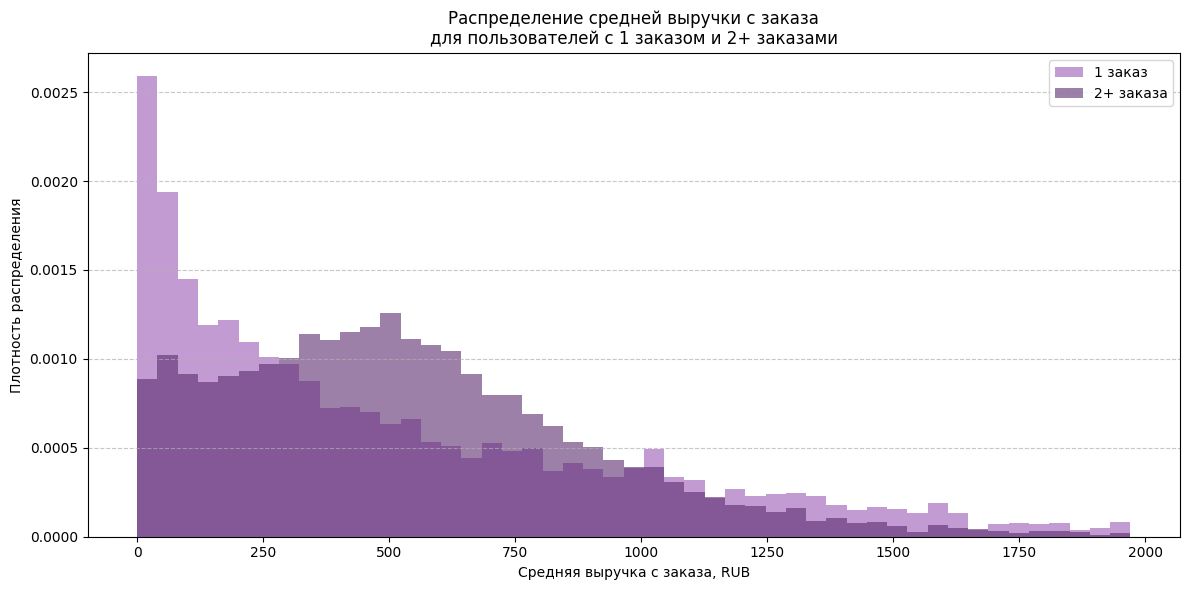

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Задаём одинаковые интервалы для обеих гистограмм
bins = np.linspace(0, p99_revenue, 50)

plt.figure(figsize=(12, 6))

# Гистограмма для пользователей с одним заказом
plt.hist(
    one_order_users[one_order_users <= p99_revenue],
    bins=bins,
    density=True,              # сравниваем форму распределений
    alpha=0.6,
    color='#9B59B6',
    label='1 заказ'
)

# Гистограмма для вернувшихся пользователей
plt.hist(
    repeat_users[repeat_users <= p99_revenue],
    bins=bins,
    density=True,
    alpha=0.6,
    color='#5B2C6F',
    label='2+ заказа'
)

plt.title('Распределение средней выручки с заказа\nдля пользователей с 1 заказом и 2+ заказами')
plt.xlabel('Средняя выручка с заказа, RUB')
plt.ylabel('Плотность распределения')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

**Визуальный анализ гистограммы**

Распределения средней выручки с заказа для пользователей с одним заказом и для вернувшихся пользователей имеют схожую форму, но заметно различаются по концентрации значений.

Пользователи, совершившие только один заказ, в большей степени сосредоточены в низких диапазонах средней выручки — прежде всего до 300–400 рублей. В этих диапазонах плотность распределения для однократных пользователей существенно выше, чем для вернувшихся.

Для пользователей, совершивших два и более заказа, распределение смещено вправо: их средняя выручка чаще находится в диапазонах от 300 до 800 рублей и выше. Кроме того, именно среди вернувшихся пользователей наблюдается более выраженный хвост распределения в области высоких значений средней выручки.

Таким образом, пользователи с более высокой средней выручкой с заказа демонстрируют большую склонность к повторным покупкам. Это подтверждает гипотезу о том, что размер и «стоимость» первого пользовательского опыта связаны с дальнейшей вовлечённостью и вероятностью возврата на платформу.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [84]:
# Группа 1: пользователи, совершившие от 2 до 4 заказов
users_2_4_orders = user_profile_filt.loc[
    user_profile_filt['orders_count'].between(2, 4),
    'avg_revenue_rub'
]

# Группа 2: пользователи, совершившие 5 и более заказов
users_5plus_orders = user_profile_filt.loc[
    user_profile_filt['orders_count'] >= 5,
    'avg_revenue_rub'
]

In [85]:
# 99-й перцентиль средней выручки с заказа
p99_revenue = user_profile_filt['avg_revenue_rub'].quantile(0.99)

p99_revenue

np.float64(1970.3100000000002)

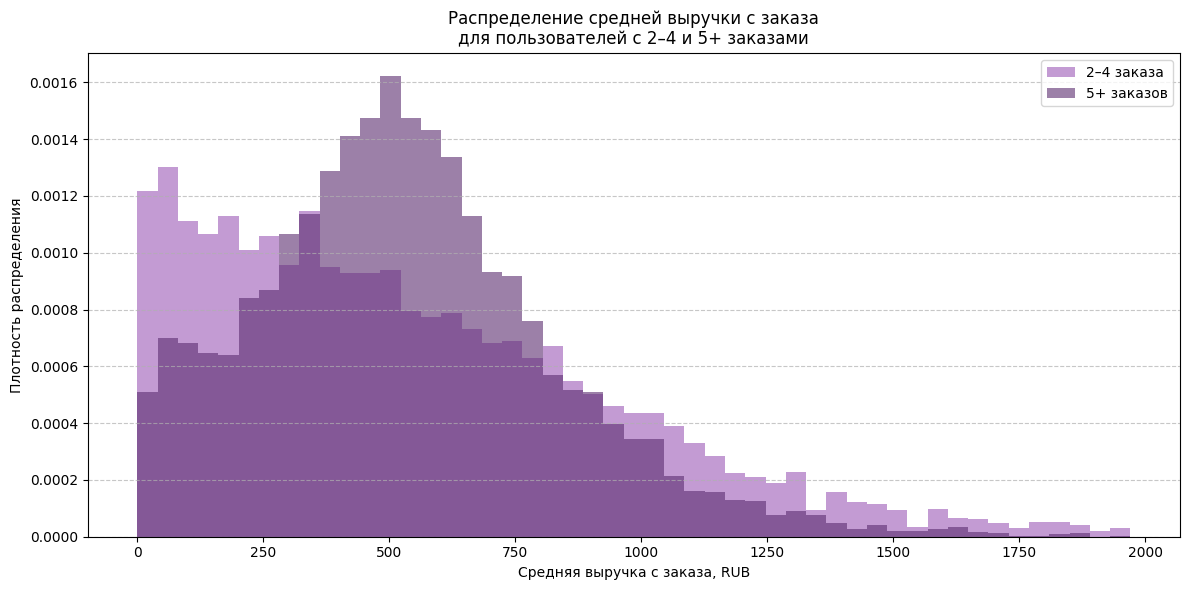

In [86]:

# Задаём одинаковые интервалы для обеих гистограмм
bins = np.linspace(0, p99_revenue, 50)

plt.figure(figsize=(12, 6))

# Гистограмма для пользователей с 2–4 заказами
plt.hist(
    users_2_4_orders[users_2_4_orders <= p99_revenue],
    bins=bins,
    density=True,              # сравниваем форму распределений
    alpha=0.6,
    color='#9B59B6',
    label='2–4 заказа'
)

# Гистограмма для пользователей с 5 и более заказами
plt.hist(
    users_5plus_orders[users_5plus_orders <= p99_revenue],
    bins=bins,
    density=True,
    alpha=0.6,
    color='#5B2C6F',
    label='5+ заказов'
)

plt.title('Распределение средней выручки с заказа\nдля пользователей с 2–4 и 5+ заказами')
plt.xlabel('Средняя выручка с заказа, RUB')
plt.ylabel('Плотность распределения')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()


**Анализ гистограмм**

1) По обеим группам основная масса пользователей сосредоточена в диапазоне примерно 200–900 руб. средней выручки с заказа. При этом наиболее выраженный пик плотности для обеих групп находится в районе ~400–600 руб, то есть типичные значения средней выручки у пользователей с 2–4 и с 5+ заказами в целом близки. Кроме того, заметны следующие наблюдения:
    - у группы 2–4 заказа визуально заметнее присутствие пользователей в более высоких значениях (правый хвост) — примерно 1000+ RUB и дальше;
    - у группы 5+ заказов распределение выглядит более “собранным” вокруг центрального диапазона, хвост присутствует, но выражен слабее.
2) Существенного разрыва между группами по средней выручке с заказа не наблюдается: распределения сильно перекрываются, центральные диапазоны и пики находятся примерно в одних и тех же зонах. Однако различия есть, но они умеренные и проявляются в форме распределений:
    - 2–4 заказа: чаще встречаются пользователи с более высокой средней выручкой (хвост правее и заметнее).
    - 5+ заказов: распределение выглядит более концентрированным в средних значениях и менее «растянутым» вправо.

Различия по средней выручке с заказа между пользователями с 2–4 и с 5+ заказами выражены слабо: центральные значения близки, распределения сильно перекрываются. При этом у пользователей с 2–4 заказами чуть сильнее выражен сегмент с высокой средней выручкой (правый хвост), а у пользователей с 5+ заказами распределение более концентрировано вокруг средних значений.

Это позволяет предположить, что переход от 2–4 заказов к 5+ заказам связан в большей степени **с регулярностью покупок**, а не с заметным ростом среднего чека. То есть высокая лояльность выражается скорее в частоте повторных покупок, чем в систематически более дорогих заказах.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

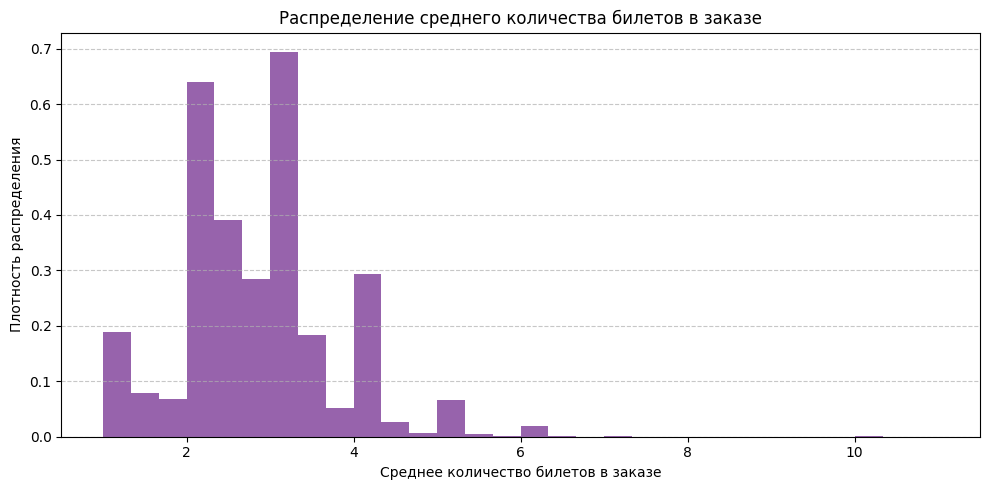

In [87]:
# Строим распределение среднего количества билетов в заказе
# Используем плотность распределения, чтобы корректно оценить форму
plt.figure(figsize=(10, 5))

plt.hist(
    user_profile_filt['avg_tickets'],
    bins=30,
    density=True,
    color='#7D3C98',
    alpha=0.8
)

plt.title('Распределение среднего количества билетов в заказе')
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Плотность распределения')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Анализ гистограммы**

Распределение среднего количества билетов в заказе является выраженно неравномерным. Основная масса пользователей сосредоточена в диапазоне от 2 до 3 билетов, а также частично в диапазоне 1–2 билета. Сегменты с более крупными заказами (3–5 и особенно 5+ билетов) представлены значительно меньшим числом пользователей и формируют правый хвост распределения.

Это означает, что:
- покупка 2–3 билетов является наиболее типичным пользовательским сценарием;
- средние значения выше 5 билетов встречаются редко и относятся к нетипичному поведению.

In [88]:
# Создаём категориальный признак — сегмент по среднему количеству билетов
user_profile_filt['tickets_segment'] = pd.cut(
    user_profile_filt['avg_tickets'],
    bins=[1, 2, 3, 5, float('inf')],
    right=True,
    include_lowest=True,
    labels=[
        '1–2 билета',
        '2–3 билета',
        '3–5 билетов',
        '5+ билетов'
    ]
)

Переводим количественный признак в категориальный, что позволяет анализировать поведение пользователей по сегментам с разной «величиной» заказа.

In [89]:
# Группируем пользователей по сегментам среднего количества билетов
tickets_segment_stats = (
    user_profile_filt
    .groupby('tickets_segment', observed=True)
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')
    )
)

# Переводим долю возврата в проценты
tickets_segment_stats['return_rate_pct'] = (
    tickets_segment_stats['return_rate'] * 100
)

tickets_segment_stats

,users_count,return_rate,return_rate_pct
tickets_segment,,,
1–2 билета,6160,0.401461,40.146104
2–3 билета,9935,0.742828,74.282838
3–5 билетов,5349,0.627033,62.703309
5+ билетов,194,0.324742,32.474227


Пользователи распределены по сегментам неравномерно: почти 75% пользователей сосредоточены в сегментах 1–2 и 2–3 билета, тогда как сегмент 5+ билетов является малочисленным и включает менее 1% пользователей.

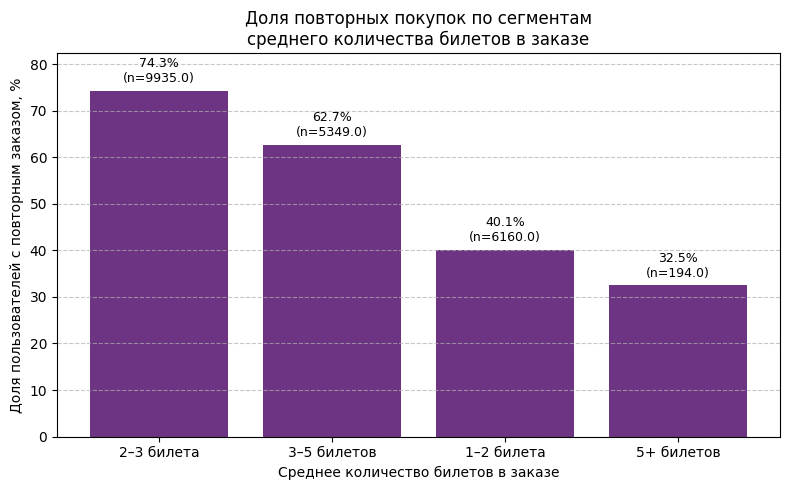

In [90]:
tickets_segment_stats_sorted = tickets_segment_stats.sort_values('return_rate_pct', ascending=False) 

plt.figure(figsize=(8, 5))

bars = plt.bar(
    tickets_segment_stats_sorted.index,
    tickets_segment_stats_sorted['return_rate_pct'],
    color='#6C3483'
)

plt.title('Доля повторных покупок по сегментам\nсреднего количества билетов в заказе')
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Доля пользователей с повторным заказом, %')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0, tickets_segment_stats_sorted['return_rate_pct'].max() + 8)

# Подписи над столбцами: доля + количество пользователей
for i, bar in enumerate(bars):
    height = bar.get_height()
    users =  tickets_segment_stats_sorted.iloc[i]['users_count']
    
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1.2,
        f'{height:.1f}%\n(n={users})',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()

- Наиболее высокая доля повторных покупок наблюдается у пользователей, которые в среднем покупают 2–3 билета. Этот сегмент демонстрирует максимальную вероятность возврата (>74%) и при этом является самым многочисленным по кол-ву заказов.
- Пользователи со средним количеством билетов 3–5 также демонстрируют повышенную вероятность возврата (около 63%), однако она ниже, чем у сегмента 2–3 билета. Эти наблюдения могут означать, что:
    - покупка нескольких билетов связана с вовлечённостью,
    - но дальнейшее увеличение количества билетов не приводит к линейному росту лояльности.
- Пользователи, покупающие в среднем 1–2 билета, возвращаются заметно реже (около 40%). Это может указывать на разовый интерес к мероприятиям.
- Сегмент 5+ билетов демонстрирует наименьшую долю повторных покупок (около 32%). Однако этот результат следует интерпретировать с осторожностью, так как сегмент является малочисленным (менее 200 пользователей), и доли возвратов в нём могут быть нестабильными.

Итоговые выводы: 
1) **Как распределены пользователи по сегментам — равномерно или сконцентрировано?**
`Пользователи распределены по сегментам неравномерно, с выраженной концентрацией в диапазоне среднего количества билетов от 2 до 3. Сегменты с большим числом билетов представлены значительно меньшим числом пользователей.`
2) **Есть ли сегменты с аномально высокой или низкой долей повторных покупок?**
`Да. Сегмент 2–3 билета является сегментом с аномально высокой долей повторных покупок и может рассматриваться как одна из наиболее успешных точек входа. Сегмент 5+ билетов демонстрирует низкую долю возвратов, однако из-за малого размера выборки этот результат нельзя считать устойчивым.`

Анализ показал, что среднее количество билетов в заказе связано с вероятностью повторной покупки, однако эта связь носит нелинейный характер. Максимальная доля возвратов наблюдается у пользователей, покупающих в среднем 2–3 билета за заказ, при этом данный сегмент является самым массовым.

Покупка меньшего количества билетов (1–2) связана с более низкой вероятностью возврата, а увеличение среднего количества билетов свыше 3 не приводит к дальнейшему росту лояльности. Сегменты с экстремальными значениями (5+ билетов) малочисленны и требуют осторожной интерпретации.

Таким образом, среднее количество билетов в заказе может рассматриваться как важный индикатор вовлечённости пользователей, при этом наиболее перспективным сегментом с точки зрения удержания являются пользователи, приобретающие 2–3 билета за заказ.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---

In [91]:
# Создаём копию, чтобы не менять исходный датафрейм
user_profile_tmp = user_profile_filt.copy()

# Из даты первого заказа извлекаем день недели
# Понедельник = 0, Воскр = 6
user_profile_tmp['first_order_weekday'] = (
    user_profile_tmp['first_order_dt']
    .dt.dayofweek
)

# Для наглядности сразу добавим названия дней
weekday_map = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}

user_profile_tmp['first_order_weekday_name'] = (
    user_profile_tmp['first_order_weekday']
    .map(weekday_map)
)

In [92]:
# Группируем пользователей по дню недели первого заказа
weekday_dist = (
    user_profile_tmp
    .groupby('first_order_weekday_name', observed=True)
    .agg(
        users_count=('user_id', 'count'),
        return_rate=('is_two', 'mean')  # доля пользователей с 2+ заказами
    )
)

# Переводим долю возвратов в проценты
weekday_dist['return_rate_pct'] = weekday_dist['return_rate'] * 100

# Задаём логичный порядок дней недели
weekday_order = [
    'Понедельник', 'Вторник', 'Среда',
    'Четверг', 'Пятница', 'Суббота', 'Воскресенье'
]

weekday_dist = weekday_dist.loc[weekday_order]

weekday_dist

,users_count,return_rate,return_rate_pct
first_order_weekday_name,,,
Понедельник,2930,0.630375,63.037543
Вторник,3176,0.619018,61.901763
Среда,3057,0.621851,62.185149
Четверг,3113,0.594282,59.428204
Пятница,3259,0.598343,59.834305
Суббота,3326,0.628082,62.808178
Воскресенье,2777,0.600288,60.028808


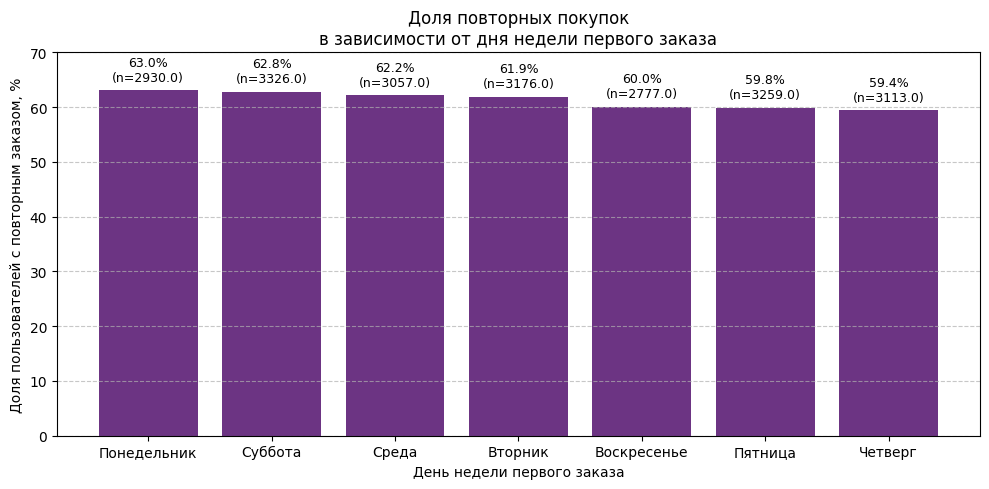

In [93]:
weekday_dist_sorted = weekday_dist.sort_values('return_rate_pct', ascending=False)

plt.figure(figsize=(10, 5))

bars = plt.bar(
    weekday_dist_sorted.index,
    weekday_dist_sorted['return_rate_pct'],
    color='#6C3483'
)

plt.title('Доля повторных покупок\nв зависимости от дня недели первого заказа')
plt.xlabel('День недели первого заказа')
plt.ylabel('Доля пользователей с повторным заказом, %')

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Немного расширяем верхнюю границу оси Y
plt.ylim(0, weekday_dist_sorted['return_rate_pct'].max() + 7)

# Подписи над столбцами: доля + количество пользователей
for i, bar in enumerate(bars):
    height = bar.get_height()
    users = weekday_dist_sorted.iloc[i]['users_count']
    
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1.2,                 # отступ вверх
        f'{height:.1f}%\n(n={users})',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()

Анализ показал, что день недели первой покупки оказывает незначительное влияние на вероятность возврата пользователя. Доли повторных покупок по дням недели различаются не более чем на 3–4 процентных пункта, а распределение пользователей по дням недели является относительно равномерным.

Таким образом, день недели первого заказа не может рассматриваться как ключевой фактор удержания пользователей и, вероятно, отражает лишь контекст совершения первой покупки, а не устойчивые различия в лояльности.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---

In [94]:
# Отбираем пользователей с валидным средним интервалом между заказами
# (то есть пользователей с 2 и более заказами)
users_with_intervals = user_profile_filt[
    user_profile_filt['avg_days_between_orders'].notna()
].copy()

# Формируем две группы пользователей:
# 1) пользователи с 2–4 заказами
group_2_4 = users_with_intervals[
    users_with_intervals['orders_count'].between(2, 4)
]

# 2) пользователи с 5 и более заказов
group_5_plus = users_with_intervals[
    users_with_intervals['orders_count'] >= 5
]

# Считаем средний интервал между заказами в каждой группе
avg_interval_2_4 = group_2_4['avg_days_between_orders'].mean()
avg_interval_5_plus = group_5_plus['avg_days_between_orders'].mean()

avg_interval_2_4, avg_interval_5_plus

(np.float64(21.32994030129192), np.float64(9.90006248453705))

In [95]:
group_2_4['avg_days_between_orders'].describe(percentiles=[0.5, 0.75, 0.9])

count       7147.0
mean      21.32994
std      28.484605
min            0.0
50%            9.0
75%           34.0
90%           59.7
max          148.0
Name: avg_days_between_orders, dtype: Float64

In [96]:
group_5_plus['avg_days_between_orders'].describe(percentiles=[0.5, 0.75, 0.9])

count       6123.0
mean      9.900062
std       7.805239
min            0.0
50%       8.117647
75%      14.111111
90%      21.193333
max           37.5
Name: avg_days_between_orders, dtype: Float64

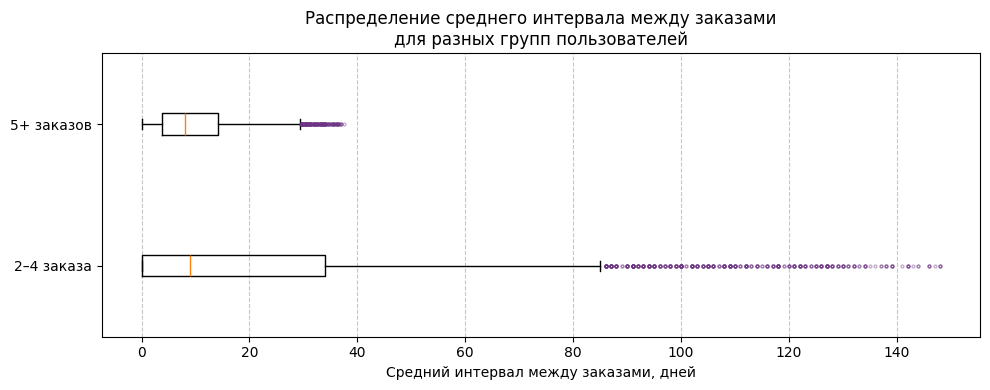

In [97]:
plt.figure(figsize=(10, 4))

plt.boxplot(
    [
        group_2_4['avg_days_between_orders'],
        group_5_plus['avg_days_between_orders']
    ],
    tick_labels=['2–4 заказа', '5+ заказов'],
    vert=False,
    flierprops=dict(
        marker='o',
        markersize=2,
        alpha=0.4,
        markeredgecolor='#6C3483'
    )
)

plt.title('Распределение среднего интервала между заказами\nдля разных групп пользователей')
plt.xlabel('Средний интервал между заказами, дней')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


**Анализ данных и boxplot**

1) 2–4 заказа:
   - 90% пользователей — до ~60 дней;
   - максимум — 148 дней;
   - высокая нестабильность поведения.
2) 5+ заказов:
    - 90% — до ~21 дня;
    - максимум — 37.5 дней;
    - поведение более регулярное и предсказуемое.

Анализ показал, что пользователи, совершившие 5 и более заказов, возвращаются на платформу значительно чаще: их средний интервал между покупками составляет около 10 дней, тогда как у пользователей с 2–4 заказами — более 21 дня. Кроме того, у лояльных пользователей интервалы между заказами более стабильны и практически не имеют длинных пауз. Это подтверждает, что частота повторных покупок является важным фактором удержания клиентов и может использоваться как ранний индикатор формирования лояльного поведения.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [98]:
import phik
from phik import phik_matrix
import seaborn as sns

In [99]:
# Признаки профиля пользователя, которые будем анализировать
corr_features = [
    'orders_count',
    'avg_revenue_rub',
    'avg_tickets',
    'avg_days_between_orders',
    'first_device',
    'first_region',
    'first_service',
    'first_event_type'
]

# Интервальные (числовые) признаки — важно для phi_k
interval_cols = [
    'orders_count',
    'avg_revenue_rub',
    'avg_tickets',
    'avg_days_between_orders'
]

In [100]:
# 1) Корреляция phi_k на всём датасете профилей пользователей (после фильтрации выбросов)
profile_df = user_profile_filt[corr_features].copy()

# 2) Считаем матрицу phi_k (важно: задаём interval_cols для числовых признаков)
phik_all = profile_df.phik_matrix(interval_cols=interval_cols)

# 3) Топ-5 признаков по связи с количеством заказов (orders_count)
top_all = (
    phik_all['orders_count']
    .drop('orders_count')
    .sort_values(ascending=False)
    .head(5)
)

top_all

avg_days_between_orders    0.284110
avg_tickets                0.225904
avg_revenue_rub            0.219482
first_region               0.113663
first_service              0.029112
Name: orders_count, dtype: float64

- Все значения phi_k умеренные или слабые: ≤ 0.28.
Это ожидаемо для поведенческих данных: количество заказов формируется не одним фактором, а комбинацией нескольких признаков.
В целом, ни один из признаков не демонстрирует сильной связи с количеством заказов, что говорит о многофакторной природе пользовательского поведения.
- Самый сильный признак — avg_days_between_orders (phi_k ≈ 0.28)
Это наиболее связанный признак с количеством заказов по всей выборке.
`Пользователи, которые совершают заказы чаще (меньший интервал между покупками), в среднем имеют больше заказов`
- Размер и стоимость заказа (avg_tickets, avg_revenue_rub)
    - avg_tickets (0.226) и avg_revenue_rub (0.219) имеют сопоставимую по силе связь.
Это говорит о том, что:
- пользователи с более крупными и/или дорогими заказами в среднем совершают больше покупок,
- но влияние этих факторов слабее, чем влияние частоты покупок.

`Размер и стоимость заказа умеренно связаны с количеством покупок, однако их влияние уступает частоте взаимодействия с сервисом.`

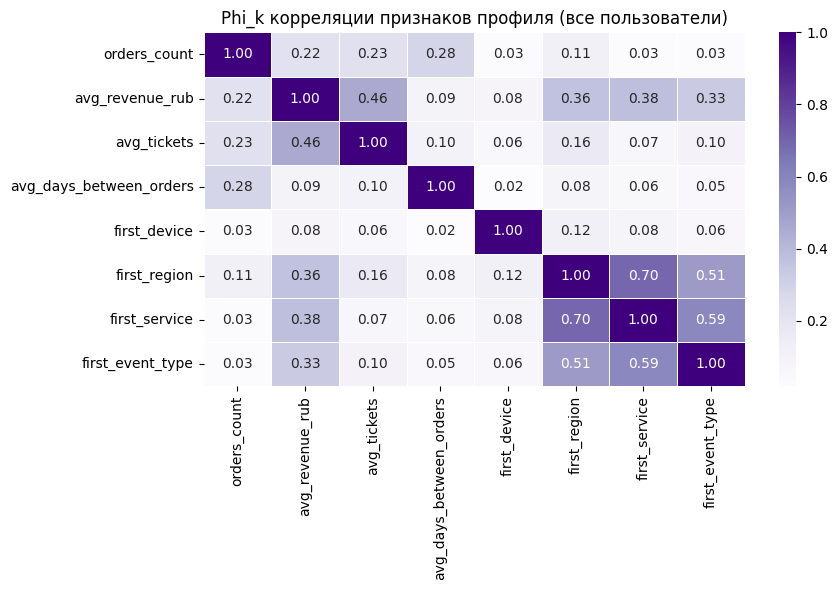

In [101]:

def plot_phik_all_heatmap(phik_all, title):
    plt.figure(figsize=(9, 6))
    sns.heatmap(
        phik_all,
        cmap='Purples',
        annot=True,
        fmt='.2f',
        linewidths=0.5
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_phik_all_heatmap(phik_all, 'Phi_k корреляции признаков профиля (все пользователи)')

Признаки первого заказа (точки входа)
- first_region — слабая связь (≈ 0.11).
- first_service — практически нулевая (≈ 0.03).

Аналогично для first_device и first_event_type.

Признаки первого заказа оказывают слабое влияние на итоговое количество заказов пользователя. Это означает, что “точка входа” важна для привлечения, но не является определяющим фактором долгосрочного поведения.

При анализе всей выборки в целом корреляции с количеством заказов оказываются сглаженными. Это связано с сильной асимметрией распределения orders_count: в данных преобладают пользователи с малым числом заказов, тогда как пользователи с частыми заказами составляют меньшинство.
В таких условиях агрегированный корреляционный анализ может занижать реальные взаимосвязи, характерные для более лояльных пользователей. Поэтому проведем отдельный анализ по серментам.

In [102]:
# Создаём сегмент по количеству заказов:
# 1 заказ
# 2–4 заказа
# 5 и более заказов
user_profile_filt['orders_segment'] = pd.cut(
    user_profile_filt['orders_count'],
    bins=[0, 1, 4, float('inf')],
    labels=['1 заказ', '2–4 заказа', '5+ заказов']
)

In [103]:
user_profile_filt['orders_segment'].value_counts()

orders_segment
1 заказ       8368
2–4 заказа    7147
5+ заказов    6123
Name: count, dtype: int64

In [104]:
def phik_top_features_safe(df, segment_name, top_n=5):
    """
    Считает phi_k для сегмента.
    Если orders_count в сегменте константа и phik её выбросил,
    то вместо топа по orders_count вернёт топ самых сильных парных связей в матрице.
    """
    segment_df = df[df['orders_segment'] == segment_name][corr_features].copy()

    # Считаем матрицу phi_k
    phik_corr = segment_df.phik_matrix(interval_cols=interval_cols)

    if 'orders_count' in phik_corr.columns:
        # Нормальный случай: orders_count есть, можно ранжировать признаки по связи с ней
        top_features = (
            phik_corr['orders_count']
            .drop('orders_count')
            .sort_values(ascending=False)
            .head(top_n)
        )
        mode = 'target_orders_count'
    else:
        # Случай сегмента "1 заказ": orders_count константа, phik её выкинул
        # Тогда покажем топ самых сильных связей между любыми признаками (кроме диагонали)
        tmp = phik_corr.copy()
        for col in tmp.columns:
            tmp.loc[col, col] = 0  # убираем диагональ 1.0
        
        # Превращаем матрицу в список пар и берём top_n максимальных значений
        pairs = (
            tmp.stack()
            .sort_values(ascending=False)
        )

        # Уберём дубли пар (A,B) и (B,A)
        seen = set()
        top_pairs = []
        for (a, b), val in pairs.items():
            if a == b:
                continue
            key = tuple(sorted([a, b]))
            if key in seen:
                continue
            seen.add(key)
            top_pairs.append((a, b, val))
            if len(top_pairs) == top_n:
                break

        top_features = pd.DataFrame(top_pairs, columns=['feature_1', 'feature_2', 'phi_k'])
        mode = 'no_target_constant_orders_count'

    return phik_corr, top_features, mode

In [105]:
phik_1, top_1, mode_1 = phik_top_features_safe(user_profile_filt, '1 заказ', top_n=5)

mode_1
top_1

/Users/leontyevalexey/Yandex.Disk.localized/ДАННЫЕ С MACBOOK 2022 - 2024/Yandex.Disk.localized/!!!2025 год/Data Science/Terminal_tasks/my_project/my_venv311/lib/python3.11/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable orders_count for analysis 1. Dropping this column
  warnings.warn(


,feature_1,feature_2,phi_k
0,avg_days_between_orders,first_region,0.935772
1,avg_days_between_orders,first_service,0.849137
2,first_service,first_region,0.667691
3,first_service,first_event_type,0.587965
4,first_event_type,avg_days_between_orders,0.517091


**Сегмент “1 заказ”**
Корреляцию “признаки - orders_count” посчитать невозможно, так как orders_count = 1.
Поэтому в этом сегменте мы можем анализировать только взаимосвязи признаков между собой.

In [106]:
phik_2_4, top_2_4, mode_2_4 = phik_top_features_safe(user_profile_filt, '2–4 заказа', top_n=5)

mode_2_4
top_2_4

avg_days_between_orders    0.385223
avg_tickets                0.369364
avg_revenue_rub            0.108758
first_service              0.072169
first_device               0.009622
Name: orders_count, dtype: float64

In [107]:
phik_5, top_5, mode_5 = phik_top_features_safe(user_profile_filt, '5+ заказов', top_n=5)
print(mode_5)
top_5

target_orders_count


avg_days_between_orders    0.695349
avg_revenue_rub            0.238158
first_region               0.164049
avg_tickets                0.162023
first_service              0.046711
Name: orders_count, dtype: float64

In [108]:
def plot_phik_heatmap(phik_corr, title):
    plt.figure(figsize=(9, 6))
    sns.heatmap(
        phik_corr,
        cmap='Purples',
        annot=True,
        fmt='.2f',
        linewidths=0.5
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

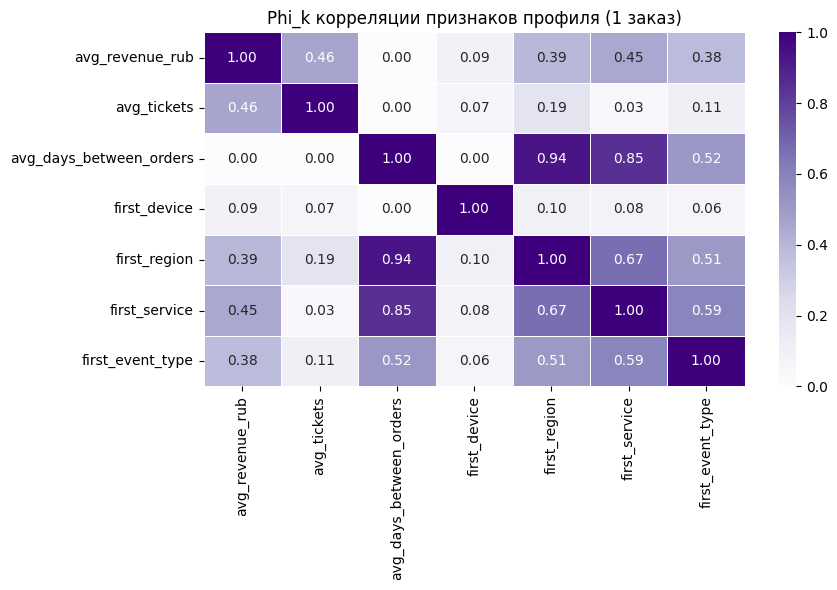

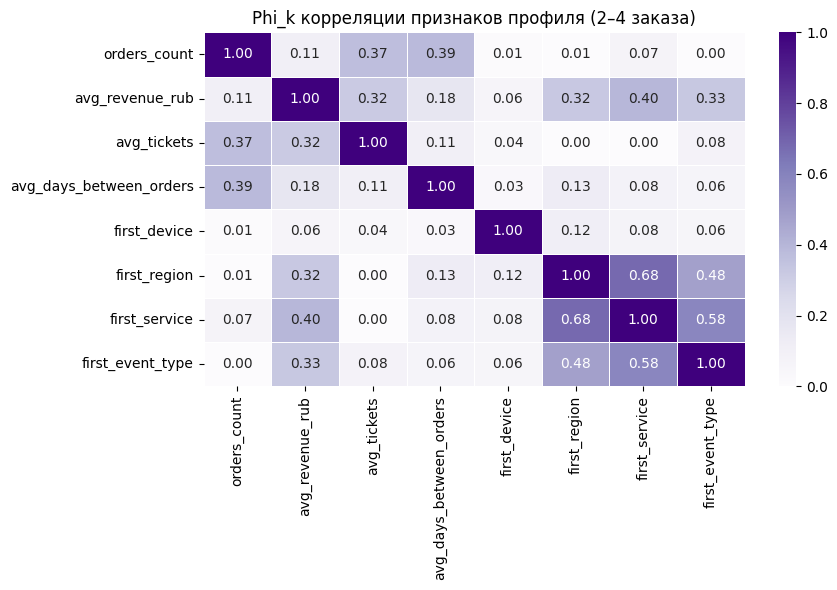

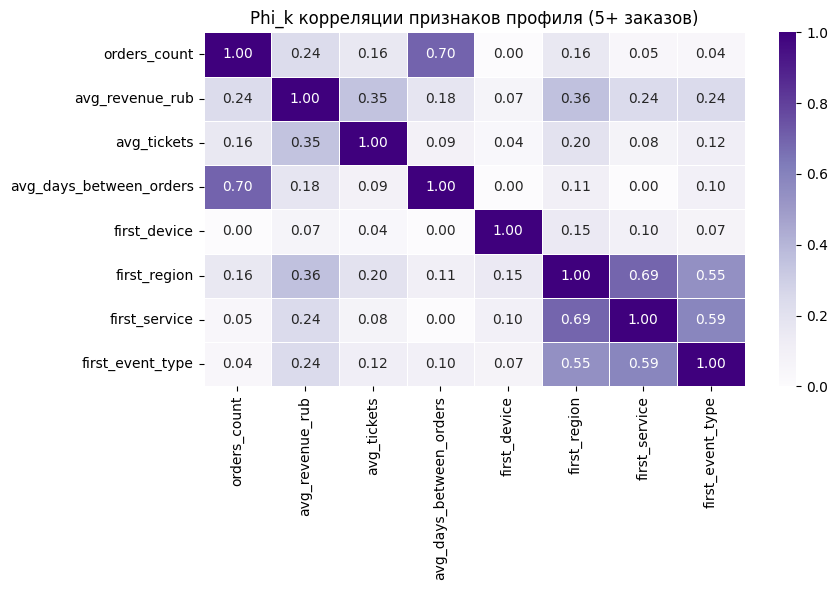

In [109]:
plot_phik_heatmap(phik_1, 'Phi_k корреляции признаков профиля (1 заказ)')
plot_phik_heatmap(phik_2_4, 'Phi_k корреляции признаков профиля (2–4 заказа)')
plot_phik_heatmap(phik_5, 'Phi_k корреляции признаков профиля (5+ заказов)')

Для сегмента (1 заказ) наблюдаются очень сильные связи:
- avg_days_between_orders -> first_region = 0.94
- avg_days_between_orders -> first_service = 0.85

Для сегмента (2-4 заказа):
- orders_count ->  avg_days_between_orders = 0.39
- orders_count -> avg_tickets = 0.37
- orders_count -> avg_revenue_rub = 0.11
- категориальные признаки первого заказа почти нулевые (≈0.00–0.07)

`Вывод по сегменту: внутри сегмента 2–4 заказа ключевые связи наблюдаются через поведение (интервал и билеты), а “точка входа” почти не влияет.`

Для сегмента (5+ закзов):
- orders_count ↔ avg_days_between_orders = 0.70 (самая сильная связь)
- orders_count ↔ avg_revenue_rub = 0.24
- orders_count ↔ avg_tickets = 0.16
- orders_count ↔ first_region = 0.16 (умеренно, но заметнее, чем в сегменте 2–4)

`Вывод по сегменту: у “лояльных” пользователей количество заказов сильнее всего связано с частотой покупок (интервалами), а также немного — с размером заказа.`

**Выводы:**

`Какие признаки наиболее связаны с количеством заказов?`

- avg_days_between_orders — наиболее связанный признак (особенно в 5+)
- avg_tickets — в 2–4 заметная связь, в 5+ слабее, но есть
- avg_revenue_rub — слабая/умеренная связь, сильнее проявляется у 5+

Категории первого заказа (first_device, first_service, first_event_type) — связи слабые, близко к нулю

first_region — слабая, но в 5+ становится заметнее

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

---

**Информация о данных**

- Исходная БД: data-analyst-afisha, схема afisha, ключевые таблицы: purchases, events, city, regions, venues.
- Для аналитического датасета выгружались заказы только с устройств mobile и desktop, редкие типы устройств исключены.
- Из датасета исключены заказы на фильмы (по event_type_main), т.к. по ним недостаточно данных (это условие вы применяли на этапе SQL-выгрузки).

Итоговый датасет заказов (после выгрузки и объединений) - df.info() после добавления курсов и пересчёта валюты:
- 290 611 заказов, 19 столбцов после merge с курсами и добавления revenue_rub.
- Ключевые признаки: user_id, order_id, order_dt, order_ts, currency_code, tickets_count, days_since_prev, event_type_main, service_name, region_name, city_name.
- Добавлены служебные поля по курсу тенге: date, nominal, rub_per_100_kzt (их можно хранить для воспроизводимости пересчёта, но в финальную витрину для EDA/модели обычно оставляют только итог revenue_rub).

Приведение выручки к единой валюте (RUB)
- В данных встречались RUB и KZT.
- Загружена таблица с курсами валюты final_tickets_tenge_df.csv, где курс дан в рублях за 100 тенге, и пересчитана выручка в revenue_rub:
    - для RUB: revenue_rub = revenue;
    - для KZT: revenue_rub = revenue * rub_per_100_kzt / 100.

Контроль качества числовых данных и выбросов
- Исходя из статистики df[['revenue_rub','tickets_count']].describe(...):
    - tickets_count: медиана 3, 99% = 6, максимум 57 (длинный хвост).
    - revenue_rub: среднее 555.6, медиана 351.1, 99% ≈ 2628.42, максимум 81 174.54 (очень длинный хвост).
- В revenue_rub есть нулевые значения (1% перцентиль = 0) и отрицательные (min = -90.76). Это важно как аномалия данных (возвраты/корректировки/ошибки).

Для визуализации и обработки выбросов по выручке ориентировались на p99 (≈2628 руб.), т.к. хвост сильно искажает масштаб и статистику.

**Профиль пользователя и объём выборки**

Построен user_profile:
- 21 854 пользователя (по user_profile.info()).
- Признаки профиля включают:
    - first_order_dt, last_order_dt;
    - first_device, first_region, first_service, first_event_type;
    - orders_count, avg_revenue_rub, avg_tickets, avg_days_between_orders;
    - бинарные: is_two, is_five.
- Пропуски в avg_days_between_orders:
    - avg_days_between_orders заполнен у 13 513 пользователей из 21 854, пропуски — это нормально, т.к. у пользователей с 1 заказом средний интервал между покупками не определён.


**Аномалии по числу заказов и фильтрация по p99**

По orders_count до фильтрации:
- median = 2, mean ≈ 13.17
- 99% = 152
- max = 10 181 заказа у одного пользователя — явная сверханомалия (и вы её отдельно проверяли).

Применили фильтр:
- p99_orders = quantile(0.99) по orders_count;
- исключили пользователей выше p99.

Результат:
- было 21 854, стало 21 638 пользователей,
- отфильтровано 216 пользователей, это ≈0.99% выборки.

После фильтрации статистика стала устойчивее:
- среднее orders_count снизилось до ~6.50 (при медиане 2),
- максимум стал 152, что соответствует p99 и убирает сверханомальных “оптовиков”.

Это корректное решение для анализа лояльности массовых пользователей: иначе несколько сверхактивных аккаунтов начинают “перетягивать” средние значения и любые зависимости.

**Распределение по числу заказов и доли возвратов**
Расчеты показали:
- доля пользователей, совершивших 2+ заказа (база возврата):
- base_return_rate = 0.6133, то есть ≈61.3% пользователей возвращаются хотя бы один раз.
- доля пользователей, совершивших 5+ заказов (по user_profile['is_five'].mean()):
    - ≈0.2901, то есть ≈29.0% пользователей достигают уровня 5+ заказов.

**Признаки первого заказа и возвраты**
Распределение по регионам первого заказа
Было определено:
- всего 81 регион;
- есть выраженные “точки входа” по регионам:

Каменевский регион: 7085 пользователей (32.7%)
Североярская область: 3767 пользователей (17.4%)
остальные 71 регион суммарно ~28%

`Вывод: распределение по регионам неравномерное, присутствуют 1–2 доминирующих источника пользователей.`


**День недели первого заказа**

Доли повторных заказов по дням недели близки:
- диапазон примерно 59.4% – 63.0%,
- различия небольшие и вряд ли являются сильным фактором удержания.

Вывод: 
- `день недели первой покупки влияет слабо (почти не влияет) — эффект на уровне нескольких процентных пунктов.`



**Связь выручки и состава заказа с повторными покупками**


**Средняя выручка с заказа и возвраты (1 заказ/более 2-х заказаов)**
- сегмент 1 заказ заметно больше концентрируется в зоне низкой средней выручки;
- сегмент 2+ заказов имеет распределение более “сдвинутое вправо” и более выраженную массу в средних значениях.

`Вывод: пользователи с повторными заказами в среднем чаще встречаются в диапазонах с более высокой средней выручкой, то есть “ценность заказа” связана с возвратом, но связь не выглядит как единственный фактор (распределения пересекаются).`

**Средняя выручка (2–4 заказа / 5+)**
- распределения групп 2–4 и 5+ близки, различия есть, но они не радикальные (визуально формы сильно пересекаются).

`Вывод: рост частоты заказов до 5+ не обязательно означает рост средней выручки с заказа — вероятнее, “5+” определяется не чеком, а частотой покупок.`

**Среднее число билетов и возвраты**
- Пользователи распределены неравномерно: самый массовый сегмент — 2–3 билета.
- Самая высокая доля повторных покупок — у сегмента 2–3 билета (74.3%).
- Сегмент 5+ билетов малочисленный (n=194), доля возврата низкая, но вывод по нему нужно трактовать аккуратно (нестабильность доли при малом размере).

**Временные характеристики и удержание пользователей**

**Интервал между заказами и уровень лояльности**

1) 2–4 заказа
    - mean ≈ 21.33 дня
    - median = 9 дней
    - max = 148

2) 5+ заказов
    - mean ≈ 9.90 дня
    - median ≈ 8.12 дня
    - max = 37.5

`Вывод:`

`- пользователи 5+ заказывают существенно чаще (средний интервал примерно в 2 раза меньше),`

`- высокая лояльность выражается в более коротком цикле повторной покупки.`

**Корреляционный анализ phi_k и факторы, связанные с числом заказов**

**Phi_k по всем пользователям**

Значения по связям с orders_count:
- avg_days_between_orders: 0.284
- avg_tickets: 0.226
- avg_revenue_rub: 0.219
- first_region: 0.114
- остальные (first_service/event_type/device): около 0.03 и ниже

`Вывод:
Наиболее связан с количеством заказов именно покупательский ритм (интервал между заказами).
“Размер заказа” (билеты/выручка) имеет умеренную связь.
Признаки первого заказа (устройство/партнёр/жанр) в целом имеют слабую связь с итоговым числом заказов.`

**Phi_k по сегментам (1, 2–4, 5+)**

По сегментам:
- 2–4 заказа: связь orders_count сильнее всего с:
- avg_days_between_orders (~0.39)
- avg_tickets (~0.37)

5+ заказов: связь orders_count особенно сильная с:
- avg_days_between_orders (~0.70) — это ключевой результат сегмента

`Вывод:
Для высоколояльных пользователей (5+) именно частота покупок становится главным маркером роста числа заказов (сильнее, чем чек и корзина).
Признаки первого заказа остаются вторичными.`

**Рекомендации заказчику**

**Сегменты для приоритетной работы (быстрый эффект)**

1) Пользователи с avg_tickets 2–3
- Самый массовый сегмент (9935 пользователей из 21638) и лучшая доля возврата (74.3%).
Рекомендация: удерживать и “дожимать” до 5+ заказов через:
    - персональные предложения,
    - подписочные механики/кэшбек на повторные покупки,
    - напоминания по афише в интервале около 7–14 дней.

2) Пользователи 2–4 заказа как зона роста
- В среднем интервал между заказами у них заметно выше, чем у 5+ (21 vs 10 дней).
Рекомендация: концентрироваться на сокращении интервала:
    - триггеры/коммуникации через 7–10 дней после покупки,
    - подборки мероприятий, похожих на первый жанр/регион,
    - ограниченные по времени предложения на 2-й/3-й заказ.

**Сегменты, требующие отдельного подхода**

1) 1–2 билета (возврат 40.1%)
Рекомендация: скорее всего это “разовые” сценарии. Нужны:
    - предложения “приведи друга / купи вдвоём”,
    - персональные рекомендации по интересам и ближайшим датам,
    - более мягкие промо на второй заказ.

2) 5+ билетов (возврат 32.5%) при n=194
Рекомендация: это может быть особый тип поведения (групповые покупки/корпоративные сценарии). Сегмент маленький — доля может быть нестабильна.
Действие: выделить отдельно и проверить:
    - какие события и операторы там доминируют,
    - нет ли там “псевдо-опта” или сервисных аккаунтов.

3) Взаимосвязью которая не позволит выработать эффективное решение

День недели первой покупки: различия 59–63% не дают сильного управленческого эффекта.
Тип устройства первого заказа и оператор первого заказа — слабая связь с числом заказов (phi_k близко к нулю).

4) Контроль аномалий и чистота данных (обязательное для дальнейших моделей)

Сверхактивные пользователи (10k+ заказов) должны быть выделены в отдельный класс или исключены из модели лояльности массовых пользователей (вы уже сделали отсечение p99 по users — это правильно).

Отрицательные и нулевые revenue_rub:
- зафиксировать как отдельный флаг (например, is_refund_or_correction),
- и принять единое правило: исключать из денежных метрик или учитывать как корректировки, чтобы не ломать ARPU/средние чеки.

**Итоговый общий вывод**

Подготовлен аналитический датасет заказов Яндекс Афиши (290 611 заказов), выручка приведена к единой валюте (руб), обработаны выбросы по orders_count через отсечение p99 пользователей (−0.99% пользователей) и построен профиль пользователя (21 854 пользователей).

`Ключевой вывод по удержанию: возврат определяется в первую очередь частотой покупок, а не только средним чеком.` Это подтверждается:
- сильной связью avg_days_between_orders с orders_count, особенно у 5+ (phi_k ~0.70),
- различием интервала между заказами (5+ покупают в среднем заметно чаще),
- высокой долей возвратов у массового сегмента avg_tickets 2–3.

Главная практическая стратегия: ускорять цикл повторной покупки у пользователей 2–4 заказов и удерживать “ядро” (2–3 билета), используя персональные триггеры и предложения в окне около 7–14 дней после покупки.

---

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

Ссылка на проект, выложенный на github:
https://github.com/Alleone/afisha-loyalty-analysis